## Introduction

Bối cảnh:
Mô hình xếp hạng tín dụng là bài toán rất nổi tiếng và có lịch sử lâu đời. Dựa theo hành trình tín dụng của KH từ lúc bắt đầu khởi tạo khoản vay tới lúc trả nợ , hành vi của khách hàng sẽ được chấm thông qua 3 loại điểm đánh giá tín dụng chính:
* Application Score (A score) : Điểm rủi ro tín dụng, ước lượng khả năng vỡ nợ (Đánh giá xem có cho vay hay ko, và nên cho vay hạn mức bao nhiêu)
* Behavior Score (B score) : Điểm hành vi tín dụng (Đánh giá hành vi tín dụng của người vay trong ngân hàng, thì nó có thể liên quan đến việc theo dõi và đánh giá hành vi thanh toán, lịch sử vay nợ và khả năng hoàn trả của người vay)
* Collection Score (C score) : Điểm khả năng thu hồi nợ (Đánh giá khả năng thu hồi nợ)



In [ ]:
!pip install catboost
!pip install toad

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
import math
import toad
from toad.metrics import KS, AUC

import time
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, auc

import warnings
import pickle
warnings.filterwarnings('ignore')

* Mục đích: Dự báo xác suất vỡ nợ của KH hay dự báo liệu KH có mất khả năng thanh toán trong kỳ hạn sắp tới hay không?
* Bộ dữ liệu này chứa thông tin về các khoản thanh toán mặc định, các yếu tố nhân khẩu học, dữ liệu tín dụng, lịch sử thanh toán và bảng sao kê hóa đơn của các khách hàng sử dụng thẻ tín dụng ở Đài Loan từ tháng 4 năm 2005 đến tháng 9 năm 2005

Có tất cả 25 features:

* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Giới tính (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Tình trạng hôn nhân (1=married, 2=single, 3=others)
* AGE: Tuổi
* PAY_0: Tình trạng thanh toán tháng 9, 2005 (-1=thanh toán hợp lệ, 1=thanh toán chậm 1 tháng, 2=thanh toán chậm 2 tháng, ... 8=thanh toán chậm 8 tháng, 9=thanh toán chậm 9 tháng hoặc hơn)
* PAY_2: Tình trạng thanh toán tháng 8, 2005 (thông tin như trên)
* PAY_3: Tình trạng thanh toán tháng 7, 2005 (thông tin như trên)
* PAY_4: Tình trạng thanh toán tháng 6 , 2005 (thông tin như trên)
* PAY_5: Tình trạng thanh toán tháng 5, 2005 (thông tin như trên)
* PAY_6: Tình trạng thanh toán tháng 4, 2005 (thông tin như trên)
* BILL_AMT1: Hoá đơn tháng 9, 2005 (NT dollar)
* BILL_AMT2: Hoá đơn tháng 8, 2005 (NT dollar)
* BILL_AMT3: Hoá đơn sao kê hoá đơn tháng 7, 2005 (NT dollar)
* BILL_AMT4: Hoá đơn sao kê hoá đơn tháng 6, 2005 (NT dollar)
* BILL_AMT5: Hoá đơn sao kê hoá đơn tháng 5, 2005 (NT dollar)
* BILL_AMT6: Hoá đơn sao kê hoá đơn tháng 4, 2005 (NT dollar)
* PAY_AMT1: Số tiền thanh toán trước đó vào tháng 9, 2005 (NT dollar)
* PAY_AMT2: Số tiền thanh toán trước đó vào tháng 8, 2005 (NT dollar)
* PAY_AMT3: Số tiền thanh toán trước đó vào tháng 7, 2005 (NT dollar)
* PAY_AMT4: Số tiền thanh toán trước đó vào tháng 6, 2005 (NT dollar)
* PAY_AMT5: Số tiền thanh toán trước đó vào tháng 5, 2005 (NT dollar)
* PAY_AMT6: Số tiền thanh toán trước đó vào tháng 4, 2005 (NT dollar)
* default.payment.next.month: Default payment (1=yes, 0=no) (Biến mục tiêu)


***Dựa theo phân loại trên và dữ liệu được sử dụng, đây là bài toán đánh giá Behavior Score của khách hàng***

## Data Overview

In [ ]:
df=pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
df = df.rename(columns={'default.payment.next.month': 'target'})
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


##EDA

In [ ]:
df.shape

(30000, 25)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

Bộ dữ liệu này không có missing values và không có biến categorical nhưng thực tế có 9 biến categorical đã được encoding `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_X (X = 0, 2, 3, 4, 5, 6)`
* SEX: Giới tính (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Tình trạng hôn nhân (1=married, 2=single, 3=others)
* PAY_X (X = 0, 2, 3, 4, 5, 6): Tình trạng thanh toán tháng (9, 8, 7, 6, 5, 4) năm 2005

In [ ]:
df['target'].value_counts()/len(df)

0    0.7788
1    0.2212
Name: target, dtype: float64

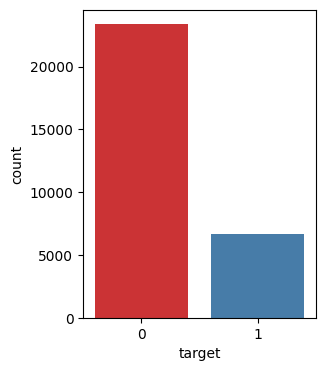

In [ ]:
f,ax = plt.subplots(figsize=(3,4))
ax = sns.countplot(x='target', data=df, palette='Set1')
plt.show()

Có thể thấy số lượng khách hàng không thực hiện các thanh toán mặc định lớn hơn rất nhiều so với những khách hàng thực hiện thanh toán (78% -
 22%). Có thể thấy dữ liệu này **không cân bằng**

In [ ]:
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [ ]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

Theo như mô tả của dữ liệu biến `EDUCATION` chỉ có các giá trị từ 1,2,3,4,5,6 nhưng đây xuất hiện cả 0 nữa => Chúng ta sẽ gộp chung những giá trị 0,5,6 thành 4 (others)

In [ ]:
fil = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
df.loc[fil, 'EDUCATION'] = 4
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [ ]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

* MARRIAGE: Tình trạng hôn nhân (1=married, 2=single, 3=others) => Gộp những giá trị bằng 0 thành 3

In [ ]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [ ]:
df['PAY_0'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64

Theo mô tả của bộ dữ liệu giá trị của `PAY_n` nếu có giá trị -1 = thanh toán hợp lệ, 1 = thanh toán chậm 1 tháng, 2 = thanh toán chậm 2 tháng, ... 8 = thanh toán chậm 8 tháng, 9 = thanh toán chậm 9 tháng hoặc nhiều hơn. Vậy những giá trị 0, -2 khả năng cao cũng là những thanh toán hợp lệ nên chúng ta sẽ gom lại thành 0 để thể hiện những thanh toán hợp lệ của KH

In [ ]:
fil = (df.PAY_0 == -2) | (df.PAY_0 == -1) | (df.PAY_0 == 0)
df.loc[fil, 'PAY_0'] = 0
fil = (df.PAY_2 == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0)
df.loc[fil, 'PAY_2'] = 0
fil = (df.PAY_3 == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0)
df.loc[fil, 'PAY_3'] = 0
fil = (df.PAY_4 == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0)
df.loc[fil, 'PAY_4'] = 0
fil = (df.PAY_5 == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0)
df.loc[fil, 'PAY_5'] = 0
fil = (df.PAY_6 == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0)
df.loc[fil, 'PAY_6'] = 0
late = df[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

In [ ]:
df['PAY_0'].value_counts()

0    23182
1     3688
2     2667
3      322
4       76
5       26
8       19
6       11
7        9
Name: PAY_0, dtype: int64

In [ ]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.842267,1.557267,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.744494,0.521405,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [ ]:
unused_feat = ['ID', 'target']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [ ]:
CATEGORICAL_COLS = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype('object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  object 
 3   EDUCATION  30000 non-null  object 
 4   MARRIAGE   30000 non-null  object 
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  object 
 7   PAY_2      30000 non-null  object 
 8   PAY_3      30000 non-null  object 
 9   PAY_4      30000 non-null  object 
 10  PAY_5      30000 non-null  object 
 11  PAY_6      30000 non-null  object 
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,0,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


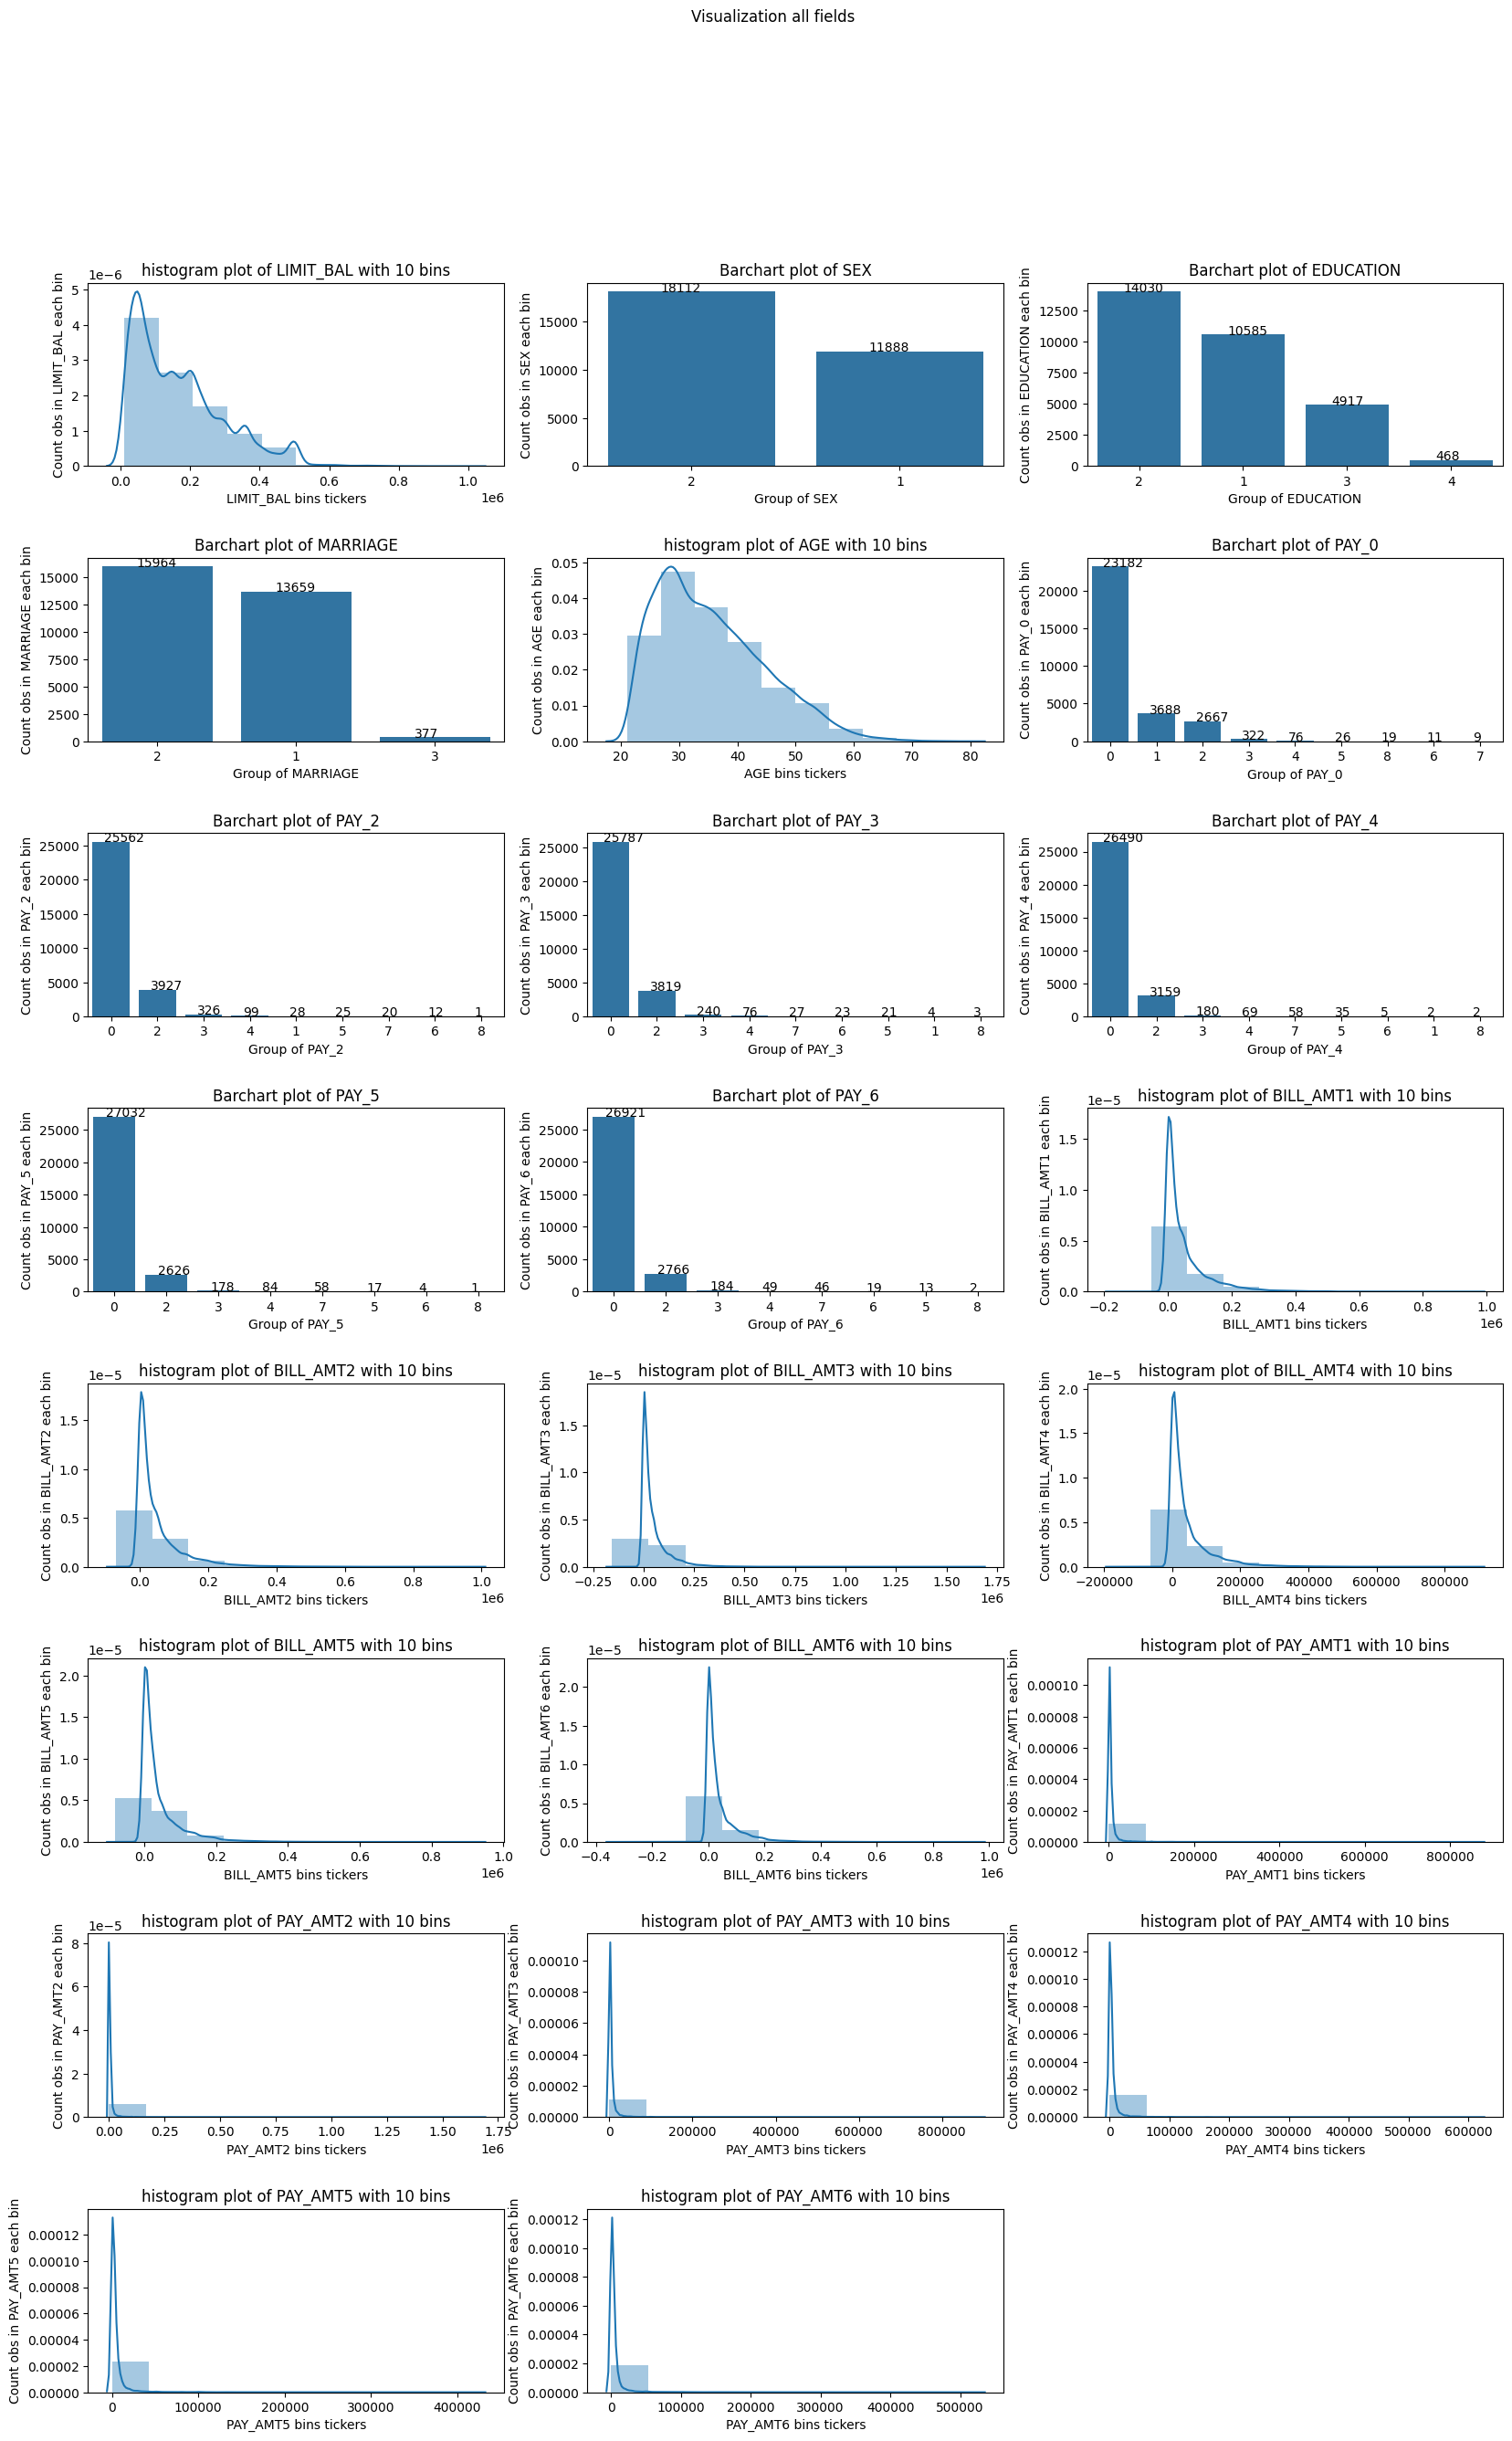

In [ ]:
# Biểu đồ histogram
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
    x = x.dropna()
    xlabel = '{} bins tickers'.format(fieldname)
    ylabel = 'Count obs in {} each bin'.format(fieldname)
    title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
    ax = sns.distplot(x, bins = bins, kde = use_kde)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return ax

# Biểu đồ barchart
def _plot_barchart_subplot(x, fieldname):
    xlabel = 'Group of {}'.format(fieldname)
    ylabel = 'Count obs in {} each bin'.format(fieldname)
    title = 'Barchart plot of {}'.format(fieldname)
    x = x.fillna('Missing')
    df_summary = x.value_counts(dropna = False)
    y_values = df_summary.values
    x_index = df_summary.index
    ax = sns.barplot(x = x_index, y = y_values, order = x_index)
    # Tạo vòng for lấy tọa độ đỉnh trên cùng của biểu đồ và thêm label thông qua annotate.
    labels = list(set(x))
    for label, p in zip(y_values, ax.patches):
      ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    return ax


def plot_all_features(df, unused_feat = None):
# Khởi tạo figure cho đồ thị (Kích thước W*H = 16x12) và cách nhau là 0.2 giữa các đồ thị
    if unused_feat is not None:
        df_plot = df.drop(unused_feat, axis = 1)
    fig = plt.figure(figsize=(20, 30))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    # Tạo vòng for check định dạng của biến và visualize
    for i, (fieldname, dtype) in enumerate(zip(df_plot.columns, df_plot.dtypes.values)):
        # if i <= 11:
            ax_i = fig.add_subplot(8, 3, i+1)
            if dtype in ['float64', 'int64']:
              ax_i = _plot_hist_subplot(df_plot[fieldname], fieldname=fieldname)
            else:
              ax_i = _plot_barchart_subplot(df_plot[fieldname], fieldname=fieldname)

    fig.suptitle('Visualization all fields')
    plt.show()

plot_all_features(df, unused_feat = unused_feat)

Tiến hành gộp các giá trị categorical có số quan sát dưới 5%

In [ ]:
for col in CATEGORICAL_COLS:
    series = pd.value_counts(df[col])
    mask = (series/series.sum() * 100).lt(5)
    # To replace df['column'] use np.where I.e
    df[col] = np.where(df[col].isin(series[mask].index), 'Other', df[col])

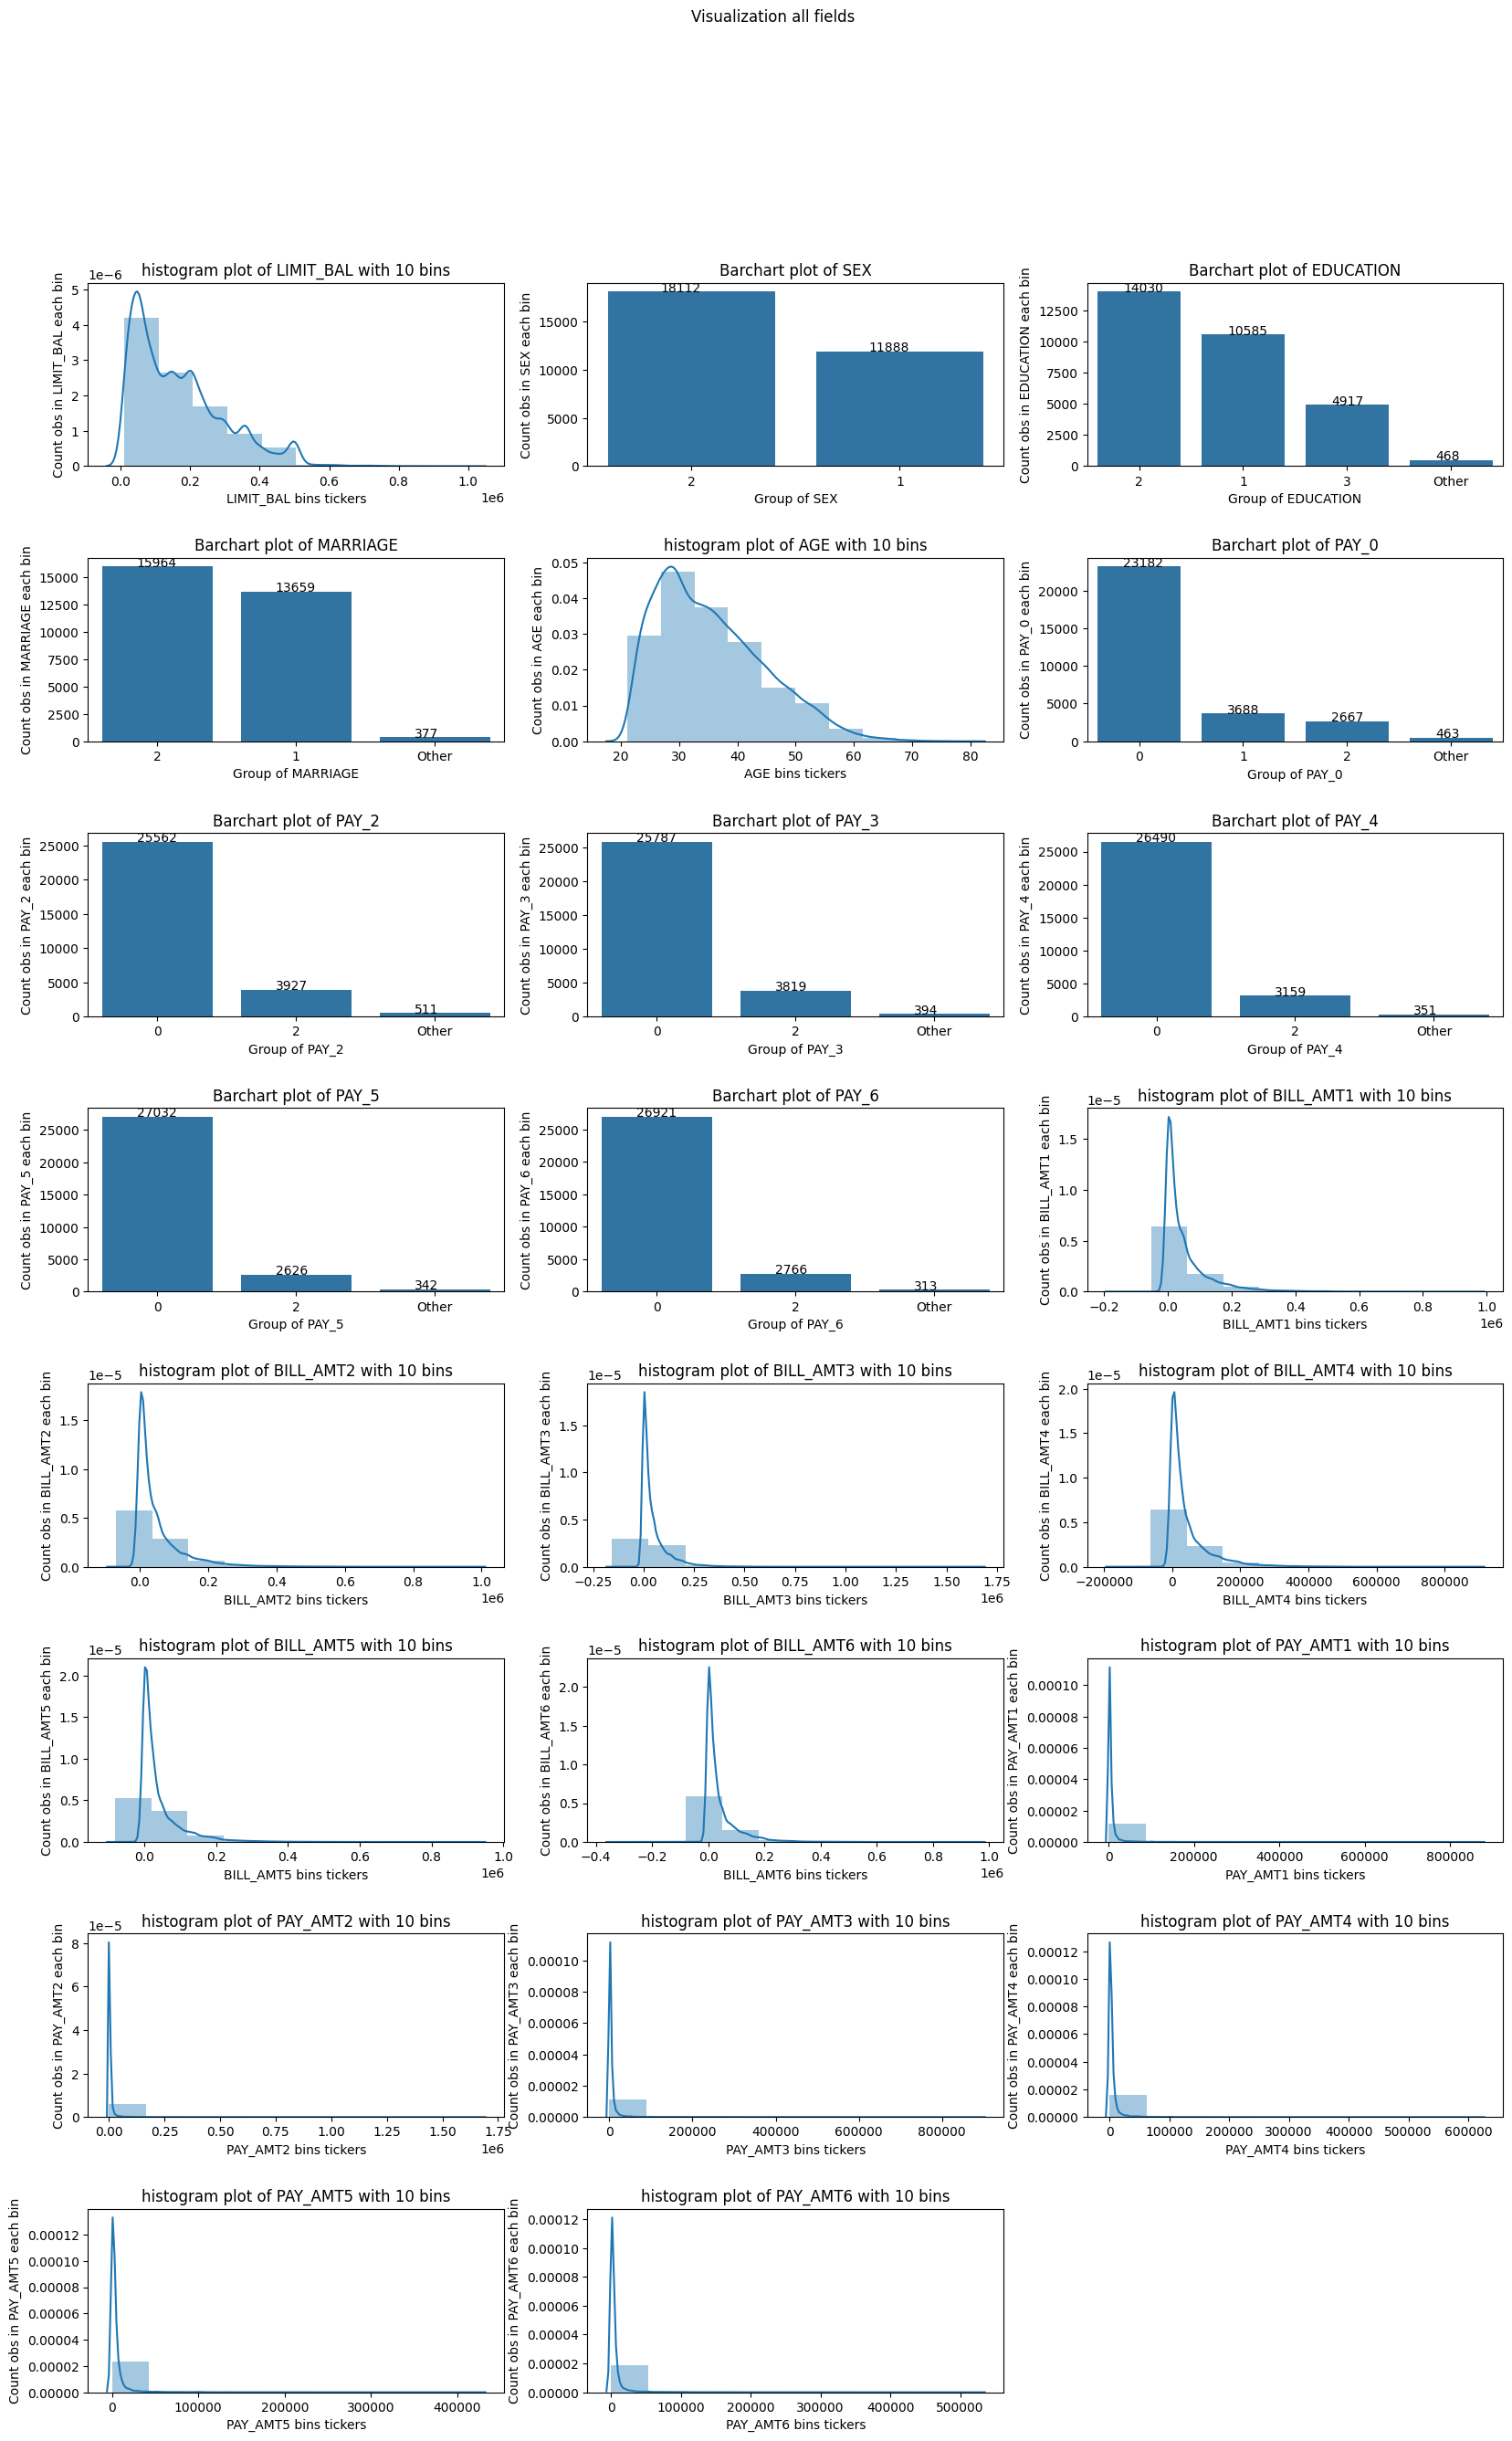

In [ ]:
plot_all_features(df, unused_feat = unused_feat)

##Spliting the Data

In [ ]:
def data_split(df, start, end, date_col):
    """
    Split the dataset into training or testing using date
    Params: (df) pandas dataframe, start, end
    Return: (df) pandas dataframe
    """
    data = df[(df[date_col] >= start) & (df[date_col] < end)]
    data = data.reset_index(drop=True)
    return data

In [ ]:
df_train = data_split(df, start = 0, end=22500, date_col='ID')
df_test = data_split(df, start = 22500, end=172792, date_col='ID')

In [ ]:
print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

df_train shape:  (22499, 25)
df_test shape:  (7501, 25)


In [ ]:
df_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,0,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22494,22495,70000.0,2,3,1,49,2,2,2,0,...,17153.0,17866.0,19413.0,4500.0,0.0,2000.0,1000.0,2000.0,691.0,1
22495,22496,50000.0,2,3,Other,46,0,0,0,0,...,19792.0,19422.0,19830.0,7084.0,1000.0,19286.0,664.0,689.0,761.0,0
22496,22497,50000.0,2,3,1,32,0,0,0,0,...,15996.0,32714.0,16720.0,1868.0,2300.0,1239.0,600.0,600.0,600.0,1
22497,22498,440000.0,2,2,1,46,0,0,0,0,...,149944.0,113135.0,105280.0,7700.0,8610.0,6907.0,3727.0,3800.0,4001.0,0


In [ ]:
df_train_tree = df_train.copy()
df_test_tree = df_test.copy()

## Feature Binning

In [ ]:
df_train.target.value_counts()

0    17411
1     5088
Name: target, dtype: int64

In [ ]:
df_train.shape

(22499, 25)

In [ ]:
MAX_VAL = float("inf")
MIN_VAL = -float("inf")

In [ ]:
def feature_binning(data, colname, n_bins = 10, thres_tunning = None):
    X = data[[colname, 'target']]
    # X = X.sort_values(colname)
    coltype = X[colname].dtype

    if coltype in ['float', 'int']:
        X = X.sort_values(colname)

        if thres_tunning is None:
            bins, thres = pd.qcut(X[colname], q = n_bins, retbins=True)
            thres[0] = MIN_VAL
            thres[-1] = MAX_VAL
            bins, thres = pd.cut(X[colname], bins=thres, retbins=True)
            X['bins'] = bins
        else:
            bins, thres = pd.cut(X[colname], bins= thres_tunning, retbins=True)
            X['bins'] = bins

    elif coltype == 'object':
        X['bins'] = X[colname]


    df_GB = pd.pivot_table(X,
                index = ['bins'],
                values = ['target'],
                columns = ['target'],
                aggfunc = {
                    'target':np.size
                })

    df_Count = pd.pivot_table(X,
                index = ['bins'],
                values = ['target'],
                aggfunc = {
                    'target': np.size
                })

    if coltype in ['float', 'int']:
        df_Thres = pd.DataFrame({'Thres':thres[1:]}, index=df_GB.index)
    elif coltype == 'object':
        df_Thres = pd.DataFrame(index=df_GB.index)
        thres = None
    df_Count.columns = ['No_Obs']
    df_Count['%Obs'] = df_Count['No_Obs'] / len(X)
    df_GB.columns = ['#Non_Default', '#Default']
    df_summary = df_Thres.join(df_Count).join(df_GB)
    return df_summary, thres

In [ ]:
df_summary, thres = feature_binning(df_train, 'LIMIT_BAL', n_bins=10)
df_summary

,Thres,No_Obs,%Obs,#Non_Default,#Default
bins,,,,,
"(-inf, 30000.0]",30000.0,3196,0.142051,2049,1147
"(30000.0, 50000.0]",50000.0,2806,0.124717,2038,768
"(50000.0, 70000.0]",70000.0,1204,0.053513,852,352
"(70000.0, 100000.0]",100000.0,2479,0.110183,1870,609
"(100000.0, 130000.0]",130000.0,1565,0.069559,1215,350
"(130000.0, 170000.0]",170000.0,2309,0.102627,1881,428
"(170000.0, 210000.0]",210000.0,2548,0.113249,2085,463
"(210000.0, 260000.0]",260000.0,1962,0.087204,1629,333
"(260000.0, 360000.0]",360000.0,2649,0.117739,2238,411


In [ ]:
df_summary, thres = feature_binning(df_train, 'EDUCATION')
df_summary

,No_Obs,%Obs,#Non_Default,#Default
bins,,,,
1,7982,0.354771,6407,1575
2,10633,0.472599,8067,2566
3,3581,0.159163,2654,927
Other,303,0.013467,283,20


In [ ]:
def _WOE(data, colname, n_bins = None, thres_tunning = None):
    # Thống kê bins và lấy ra thres hold ban đầu
    df_summary, thres = feature_binning(data, colname, n_bins = n_bins, thres_tunning = thres_tunning )
    # Thay thế giá trị 0 của #BAD trong df_summary bằng 1 để không bị lỗi chia cho 0
    df_summary['#Default'] = df_summary['#Default'].replace({0:1})

    df_summary['Default/Non_Default'] = df_summary['#Default']/df_summary['#Non_Default']
    df_summary['%Default'] = df_summary['#Default']/df_summary['#Default'].sum()
    df_summary['%Non_Default'] = df_summary['#Non_Default']/df_summary['#Non_Default'].sum()
    df_summary['WOE'] = np.log(df_summary['%Default']/df_summary['%Non_Default'])
    df_summary['IV'] = (df_summary['%Default']-df_summary['%Non_Default'])*df_summary['WOE']
    df_summary['COLUMN'] = colname
    IV = df_summary['IV'].sum()
    print('Information Value of {} column: {}'.format(colname, IV))
    return df_summary, IV, thres

In [ ]:
# We set the default style of the graphs to the seaborn style.
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    colname = list(df_summary['COLUMN'].unique())[0]
    x = np.array([str(element) for element in df_WoE.index.tolist()])
    y = df_WoE['WOE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel('Bin group')
    plt.ylabel('Weight of Evidence')
    plt.title('Weight of Evidence of {} field'.format(colname))
    plt.axhline(y=0, color = 'red')
    plt.xticks(rotation = rotation_of_x_axis_labels)

In [ ]:
WOE_dict=dict()

### LIMIT_BAL

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'LIMIT_BAL', n_bins = 10)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of LIMIT_BAL column: 0.16407862853528818


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 30000.0]",30000.000000,3196,0.142051,2049,1147,0.559785,0.225432,0.117684,0.650015,0.070038,LIMIT_BAL
"(30000.0, 50000.0]",50000.000000,2806,0.124717,2038,768,0.376840,0.150943,0.117052,0.254283,0.008618,LIMIT_BAL
"(50000.0, 70000.0]",70000.000000,1204,0.053513,852,352,0.413146,0.069182,0.048935,0.346262,0.007011,LIMIT_BAL
"(70000.0, 100000.0]",100000.000000,2479,0.110183,1870,609,0.325668,0.119693,0.107403,0.108342,0.001332,LIMIT_BAL
"(100000.0, 130000.0]",130000.000000,1565,0.069559,1215,350,0.288066,0.068789,0.069783,-0.014349,0.000014,LIMIT_BAL
"(130000.0, 170000.0]",170000.000000,2309,0.102627,1881,428,0.227539,0.084119,0.108035,-0.250218,0.005984,LIMIT_BAL
"(170000.0, 210000.0]",210000.000000,2548,0.113249,2085,463,0.222062,0.090998,0.119752,-0.274580,0.007895,LIMIT_BAL
"(210000.0, 260000.0]",260000.000000,1962,0.087204,1629,333,0.204420,0.065448,0.093562,-0.357362,0.010047,LIMIT_BAL
"(260000.0, 360000.0]",360000.000000,2649,0.117739,2238,411,0.183646,0.080778,0.128539,-0.464527,0.022186,LIMIT_BAL


In [ ]:
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0).fit(df_train[['BILL_AMT1_WOE']], df_train['target'])

In [ ]:
# clf.coef_

In [ ]:
# clf.intercept_

In [ ]:
# print(np.log(len(df_train[df_train['target'] == 1]) / len(df_train[df_train['target'] == 0])))

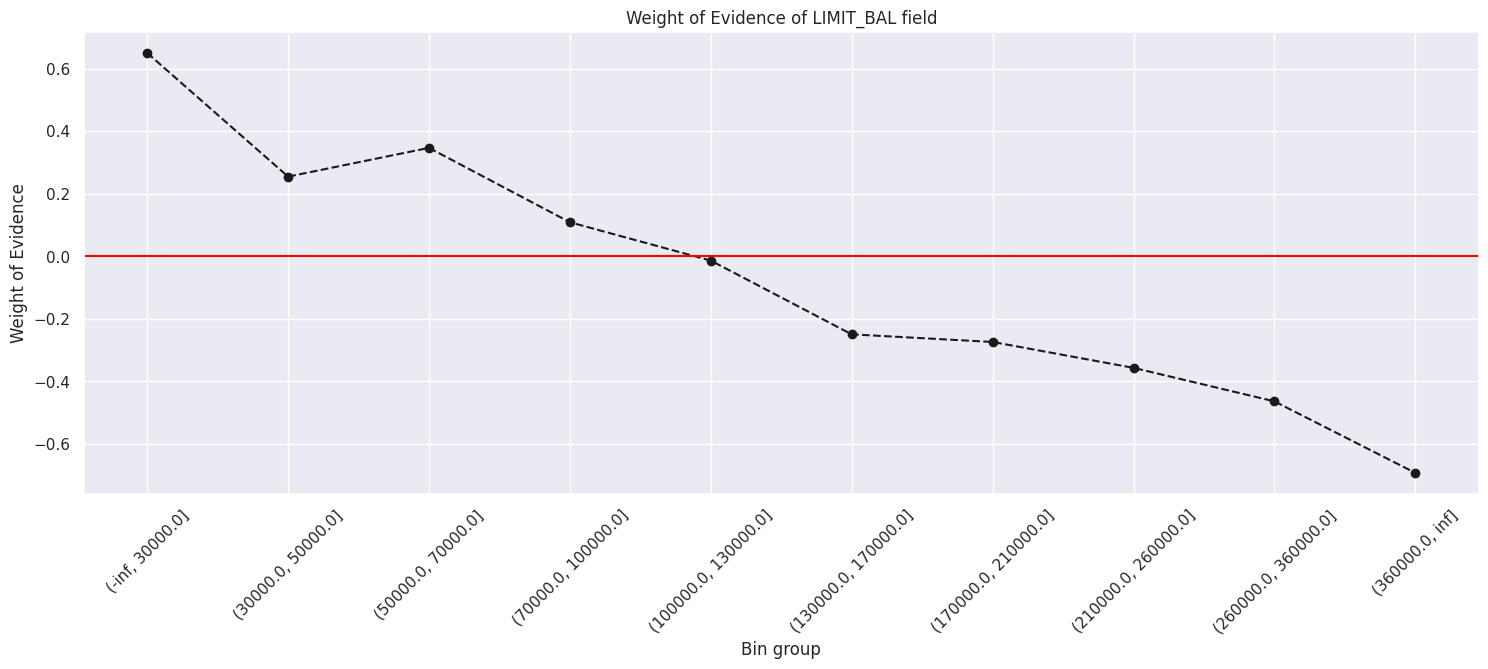

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['LIMIT_BAL'] = {'table':df_summary, 'IV':IV}

### SEX

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'SEX')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of SEX column: 0.008270368975393537


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
1,8771,0.389840,6612,2159,0.326528,0.424332,0.379760,0.110976,0.004946,SEX
2,13728,0.610160,10799,2929,0.271229,0.575668,0.620240,-0.074575,0.003324,SEX


In [ ]:
WOE_dict['SEX'] = {'table':df_summary, 'IV':IV}

### EDUCATION

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'EDUCATION')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of EDUCATION column: 0.03638077634388631


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
1,7982,0.354771,6407,1575,0.245825,0.309552,0.367986,-0.172919,0.010104,EDUCATION
2,10633,0.472599,8067,2566,0.318086,0.504324,0.463328,0.084784,0.003476,EDUCATION
3,3581,0.159163,2654,927,0.349284,0.182193,0.152432,0.178348,0.005308,EDUCATION
Other,303,0.013467,283,20,0.070671,0.003931,0.016254,-1.419497,0.017493,EDUCATION


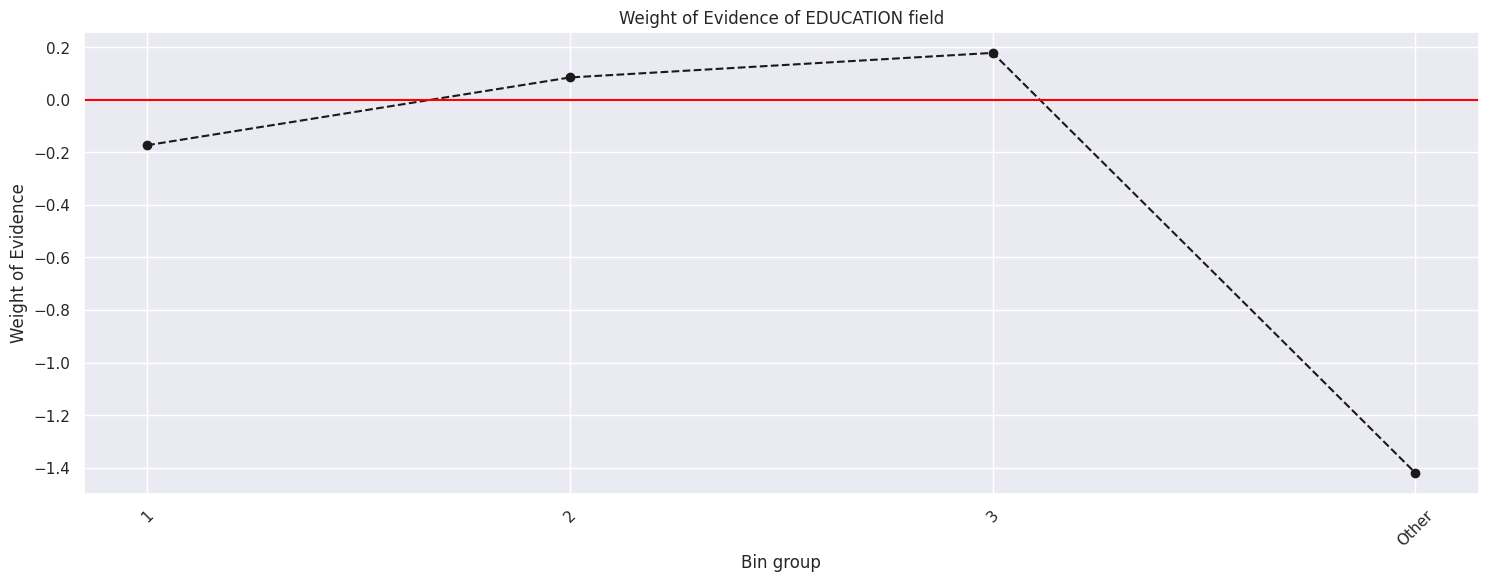

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['EDUCATION'] = {'table':df_summary, 'IV':IV}

### MARRIAGE

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'MARRIAGE')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of MARRIAGE column: 0.007136970884237461


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
1,9989,0.443975,7566,2423,0.320248,0.476219,0.434553,0.091559,0.003815,MARRIAGE
2,12219,0.543091,9621,2598,0.270034,0.510613,0.552582,-0.078989,0.003315,MARRIAGE
Other,291,0.012934,224,67,0.299107,0.013168,0.012865,0.023264,0.000007,MARRIAGE


In [ ]:
WOE_dict['MARRIAGE'] = {'table':df_summary, 'IV':IV}

### AGE

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'AGE', n_bins = 10)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of AGE column: 0.02222094500160811


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 25.0]",25.000000,3169,0.140851,2298,871,0.379025,0.171187,0.131986,0.260065,0.010195,AGE
"(25.0, 27.0]",27.000000,2169,0.096404,1716,453,0.263986,0.089033,0.098558,-0.101642,0.000968,AGE
"(27.0, 29.0]",29.000000,2356,0.104716,1880,476,0.253191,0.093553,0.107978,-0.143392,0.002068,AGE
"(29.0, 31.0]",31.000000,1893,0.084137,1531,362,0.236447,0.071148,0.087933,-0.211815,0.003555,AGE
"(31.0, 33.0]",33.000000,1672,0.074314,1347,325,0.241277,0.063876,0.077365,-0.191593,0.002584,AGE
"(33.0, 36.0]",36.000000,2453,0.109027,1917,536,0.279604,0.105346,0.110103,-0.044165,0.000210,AGE
"(36.0, 39.0]",39.000000,2128,0.094582,1658,470,0.283474,0.092374,0.095227,-0.030417,0.000087,AGE
"(39.0, 43.0]",43.000000,2296,0.102049,1769,527,0.297908,0.103577,0.101602,0.019248,0.000038,AGE
"(43.0, 49.0]",49.000000,2363,0.105027,1802,561,0.311321,0.110259,0.103498,0.063286,0.000428,AGE


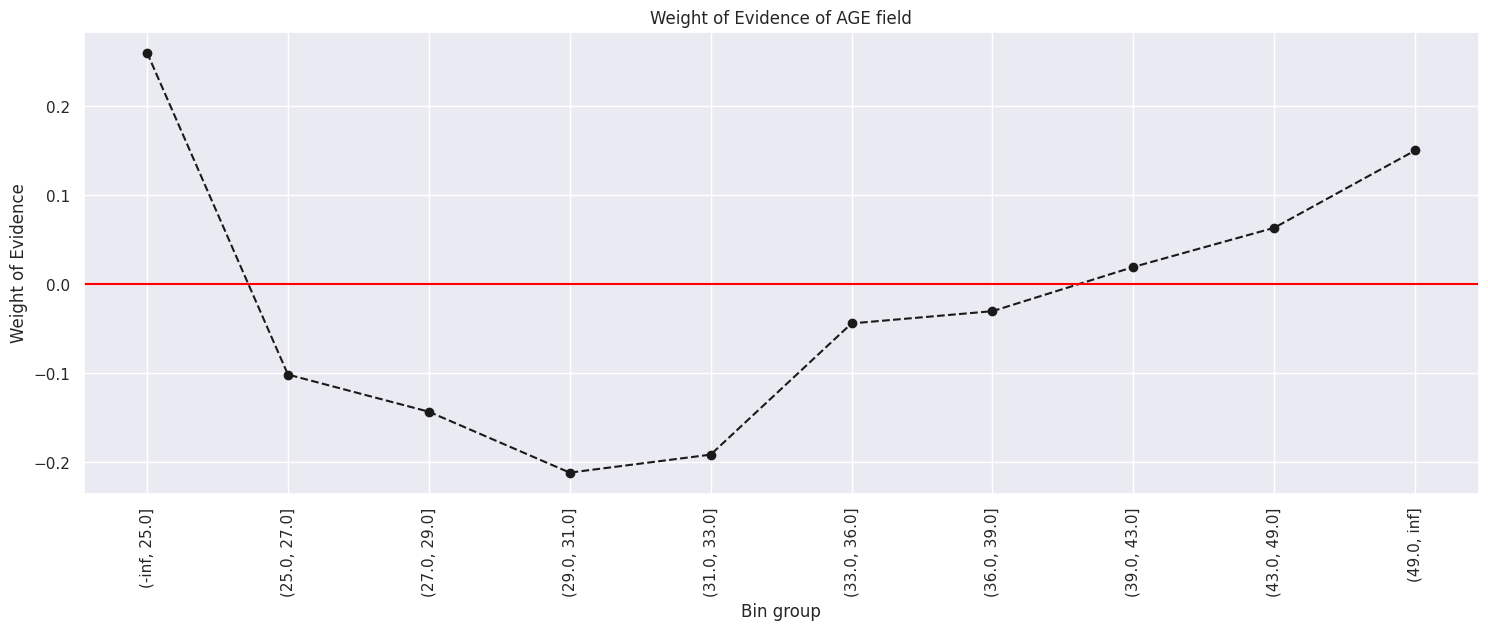

In [ ]:
plot_by_woe(df_summary, 90)

In [ ]:
# df_summary, IV, thres = _WOE(df_train, 'AGE', thres_tunning= [-float("inf"), 25, 27, 29, 39, 43, 49, float("inf")])
# df_summary.style.bar(subset=['WOE', '%Default'])

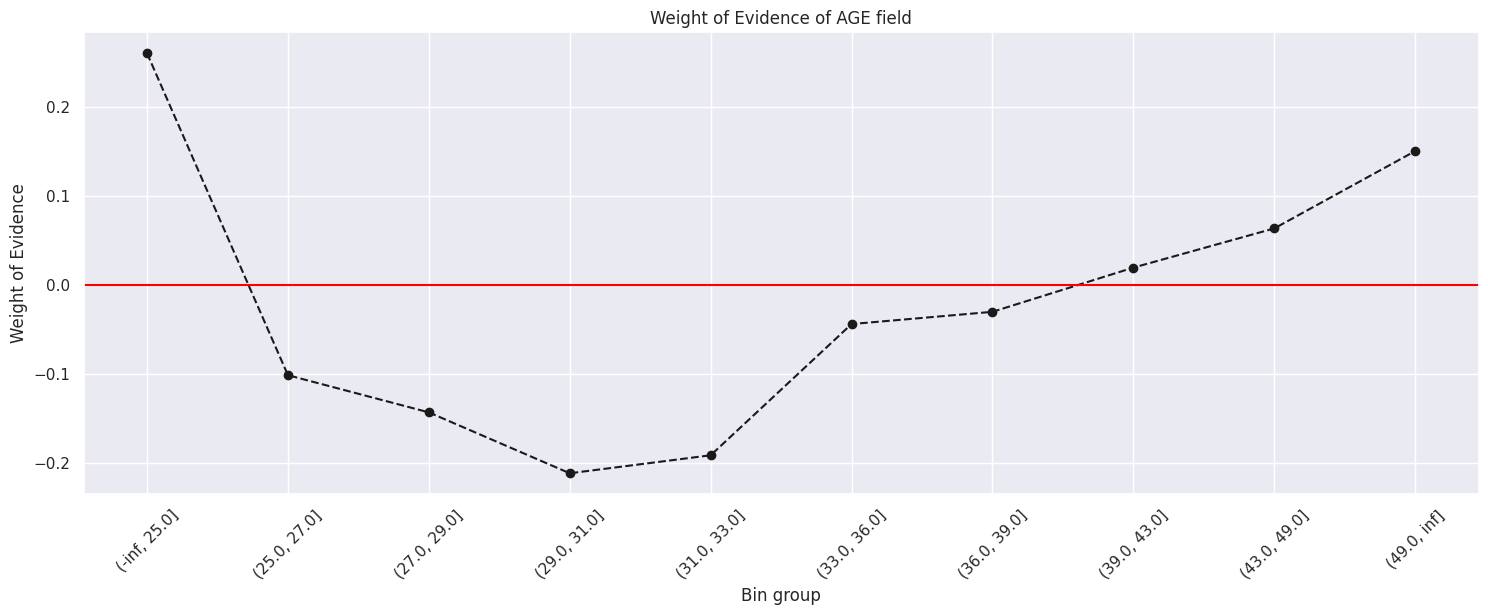

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['AGE'] = {'table':df_summary, 'IV':IV}

### PAY_0

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_0')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_0 column: 0.8431800807824921


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
0,17220,0.765367,14789,2431,0.164379,0.477791,0.849406,-0.575364,0.213814,PAY_0
1,2830,0.125783,1857,973,0.523963,0.191234,0.106657,0.583884,0.049383,PAY_0
2,2093,0.093026,662,1431,2.161631,0.281250,0.038022,2.001081,0.486719,PAY_0
Other,356,0.015823,103,253,2.456311,0.049725,0.005916,2.128878,0.093264,PAY_0


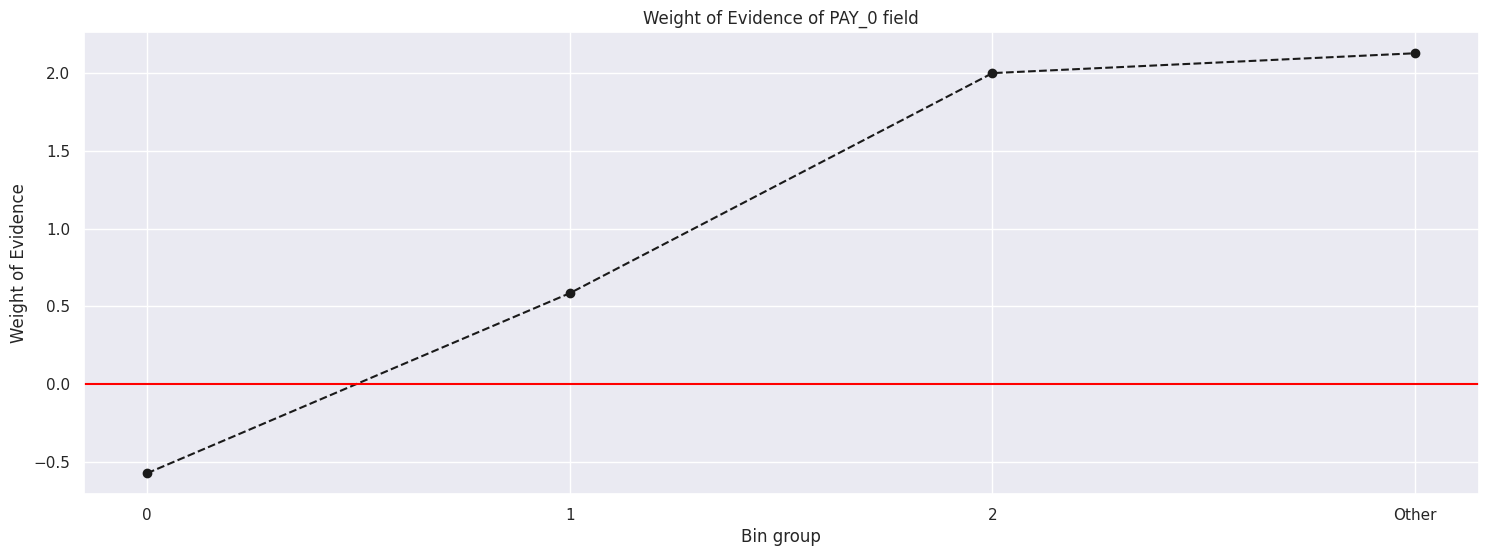

In [ ]:
plot_by_woe(df_summary)

In [ ]:
WOE_dict['PAY_0'] = {'table':df_summary, 'IV':IV}

### PAY_2

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_2')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_2 column: 0.5251806074311437


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
0,19058,0.847060,15879,3179,0.200202,0.624803,0.912010,-0.378213,0.108625,PAY_2
2,3051,0.135606,1362,1689,1.240088,0.331958,0.078226,1.445400,0.366743,PAY_2
Other,390,0.017334,170,220,1.294118,0.043239,0.009764,1.488046,0.049812,PAY_2


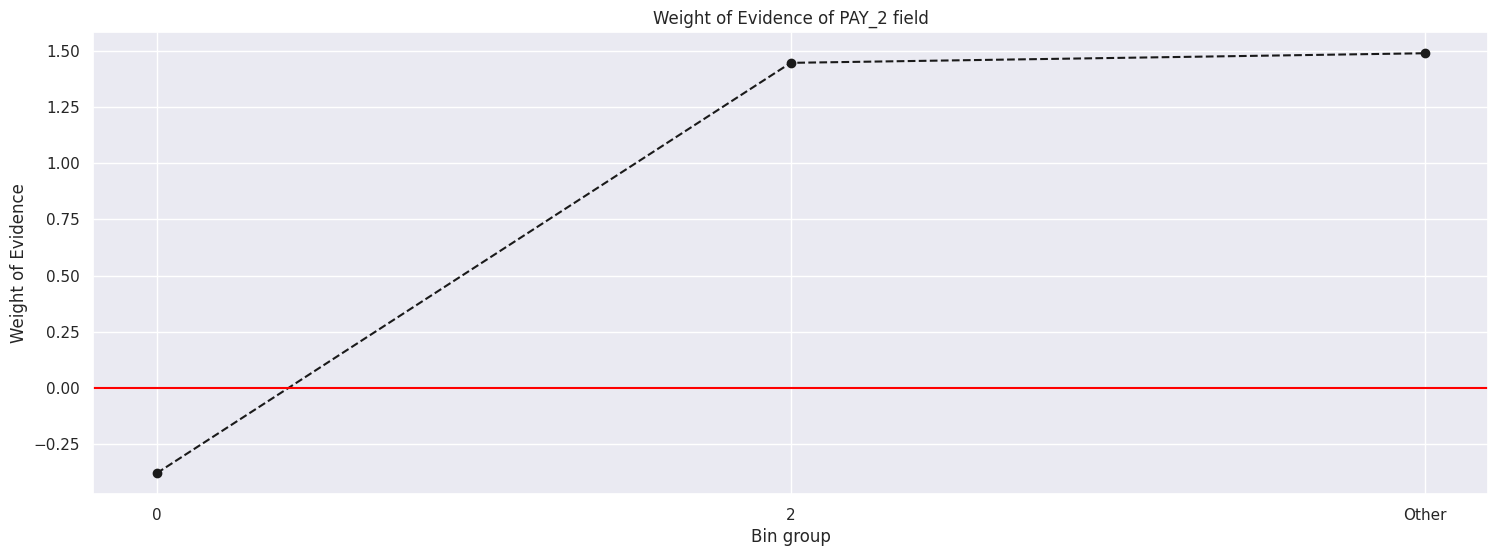

In [ ]:
plot_by_woe(df_summary)

In [ ]:
WOE_dict['PAY_2'] = {'table':df_summary, 'IV':IV}

### PAY_3

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_3')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_3 column: 0.3952704800429854


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
0,19222,0.854349,15833,3389,0.214047,0.666077,0.909368,-0.311344,0.075747,PAY_3
2,2974,0.132184,1456,1518,1.042582,0.298349,0.083625,1.271918,0.273111,PAY_3
Other,303,0.013467,122,181,1.483607,0.035574,0.007007,1.624693,0.046412,PAY_3


In [ ]:
WOE_dict['PAY_3'] = {'table':df_summary, 'IV':IV}

### PAY_4

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_4')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_4 column: 0.341826692881437


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
0,19845,0.882039,16177,3668,0.226742,0.720912,0.929125,-0.253727,0.052829,PAY_4
2,2369,0.105294,1130,1239,1.096460,0.243514,0.064901,1.322304,0.236180,PAY_4
Other,285,0.012667,104,181,1.740385,0.035574,0.005973,1.784323,0.052817,PAY_4


In [ ]:
WOE_dict['PAY_4'] = {'table':df_summary, 'IV':IV}

### PAY_5

In [ ]:
df_summary, IV, thres = _WOE(df, 'PAY_5')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_5 column: 0.33218710927991685


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
0,27032,0.901067,22045,4987,0.226219,0.751507,0.943546,-0.227564,0.043701,PAY_5
2,2626,0.087533,1203,1423,1.182876,0.214436,0.051489,1.426636,0.232466,PAY_5
Other,342,0.011400,116,226,1.948276,0.034057,0.004965,1.925632,0.056020,PAY_5


In [ ]:
WOE_dict['PAY_5'] = {'table':df_summary, 'IV':IV}

### PAY_6

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_6')
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_6 column: 0.27675890510809076


,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,
0,20028,0.890173,16208,3820,0.235686,0.750786,0.930906,-0.215037,0.038732,PAY_6
2,2222,0.098760,1119,1103,0.985702,0.216785,0.064270,1.215816,0.185430,PAY_6
Other,249,0.011067,84,165,1.964286,0.032429,0.004825,1.905346,0.052597,PAY_6


In [ ]:
WOE_dict['PAY_6'] = {'table':df_summary, 'IV':IV}

### BILL_AMT1

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'BILL_AMT1', n_bins = 10)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of BILL_AMT1 column: 0.01222242195444229


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 301.8]",301.800000,2250,0.100004,1695,555,0.327434,0.109080,0.097352,0.113747,0.001334,BILL_AMT1
"(301.8, 2000.0]",2000.000000,2254,0.100182,1752,502,0.286530,0.098664,0.100626,-0.019696,0.000039,BILL_AMT1
"(2000.0, 6348.0]",6348.000000,2247,0.099871,1755,492,0.280342,0.096698,0.100798,-0.041528,0.000170,BILL_AMT1
"(6348.0, 13937.4]",13937.400000,2249,0.099960,1733,516,0.297750,0.101415,0.099535,0.018715,0.000035,BILL_AMT1
"(13937.4, 22716.0]",22716.000000,2250,0.100004,1668,582,0.348921,0.114387,0.095802,0.177307,0.003295,BILL_AMT1
"(22716.0, 36807.6]",36807.600000,2249,0.099960,1688,561,0.332346,0.110259,0.096950,0.128639,0.001712,BILL_AMT1
"(36807.6, 51269.2]",51269.200000,2250,0.100004,1740,510,0.293103,0.100236,0.099937,0.002988,0.000001,BILL_AMT1
"(51269.2, 81854.8]",81854.800000,2250,0.100004,1781,469,0.263335,0.092178,0.102292,-0.104110,0.001053,BILL_AMT1
"(81854.8, 139026.8]",139026.800000,2250,0.100004,1800,450,0.250000,0.088443,0.103383,-0.156077,0.002332,BILL_AMT1


In [ ]:
# df_summary, IV, thres = _WOE(df, 'BILL_AMT1', thres_tunning= [-float("inf"), 37045.2, 83421.2, float("inf")])
# df_summary.style.bar(subset=['WOE', '%Default'])

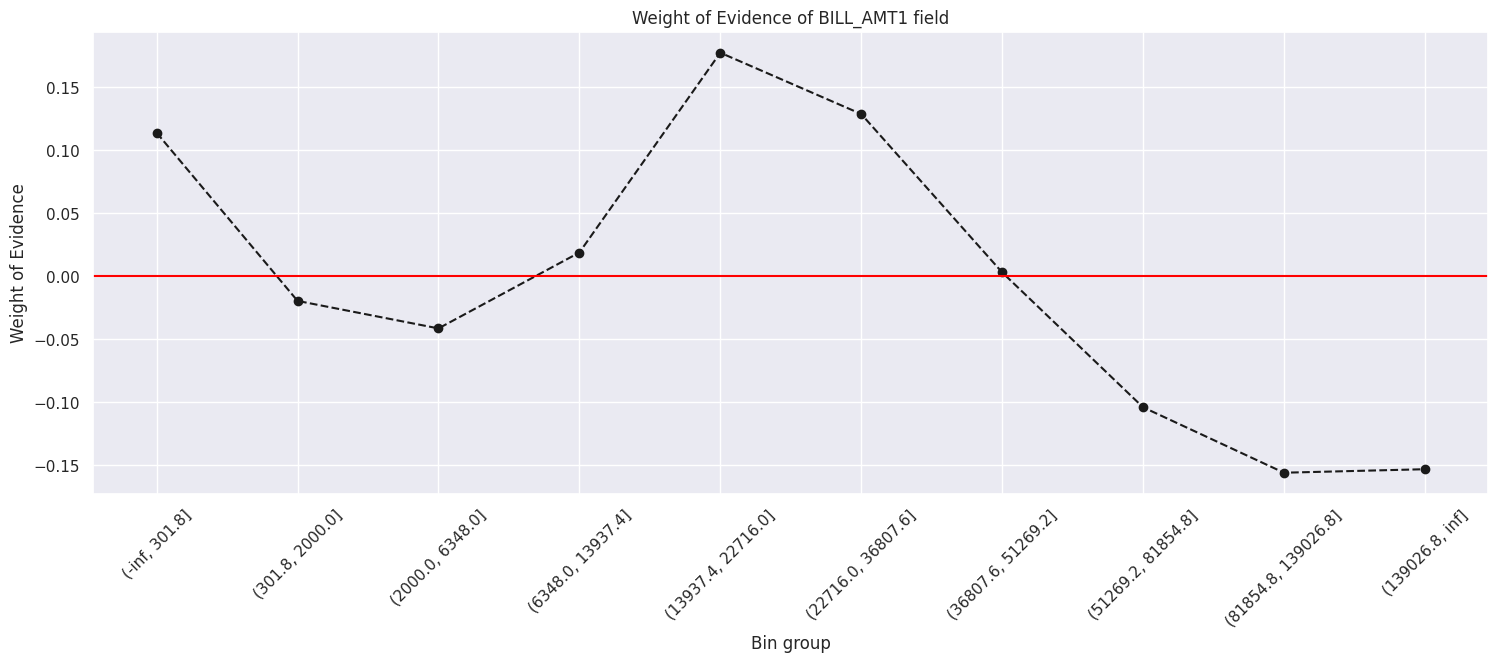

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['BILL_AMT1'] = {'table':df_summary, 'IV':IV}

### BILL_AMT2

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'BILL_AMT2', n_bins = 10)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of BILL_AMT2 column: 0.010108192428236882


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 0.0]",0.000000,2358,0.104805,1808,550,0.304204,0.108097,0.103842,0.040159,0.000171,BILL_AMT2
"(0.0, 1536.2]",1536.200000,2142,0.095204,1667,475,0.284943,0.093357,0.095744,-0.025249,0.000060,BILL_AMT2
"(1536.2, 5856.0]",5856.000000,2250,0.100004,1767,483,0.273345,0.094929,0.101488,-0.066804,0.000438,BILL_AMT2
"(5856.0, 13302.2]",13302.200000,2250,0.100004,1735,515,0.296830,0.101219,0.099650,0.015622,0.000025,BILL_AMT2
"(13302.2, 21743.0]",21743.000000,2250,0.100004,1660,590,0.355422,0.115959,0.095342,0.195767,0.004036,BILL_AMT2
"(21743.0, 34579.6]",34579.600000,2249,0.099960,1689,560,0.331557,0.110063,0.097008,0.126262,0.001648,BILL_AMT2
"(34579.6, 50277.4]",50277.400000,2250,0.100004,1735,515,0.296830,0.101219,0.099650,0.015622,0.000025,BILL_AMT2
"(50277.4, 78742.0]",78742.000000,2250,0.100004,1772,478,0.269752,0.093947,0.101775,-0.080036,0.000627,BILL_AMT2
"(78742.0, 133804.8]",133804.800000,2250,0.100004,1793,457,0.254880,0.089819,0.102981,-0.136745,0.001800,BILL_AMT2


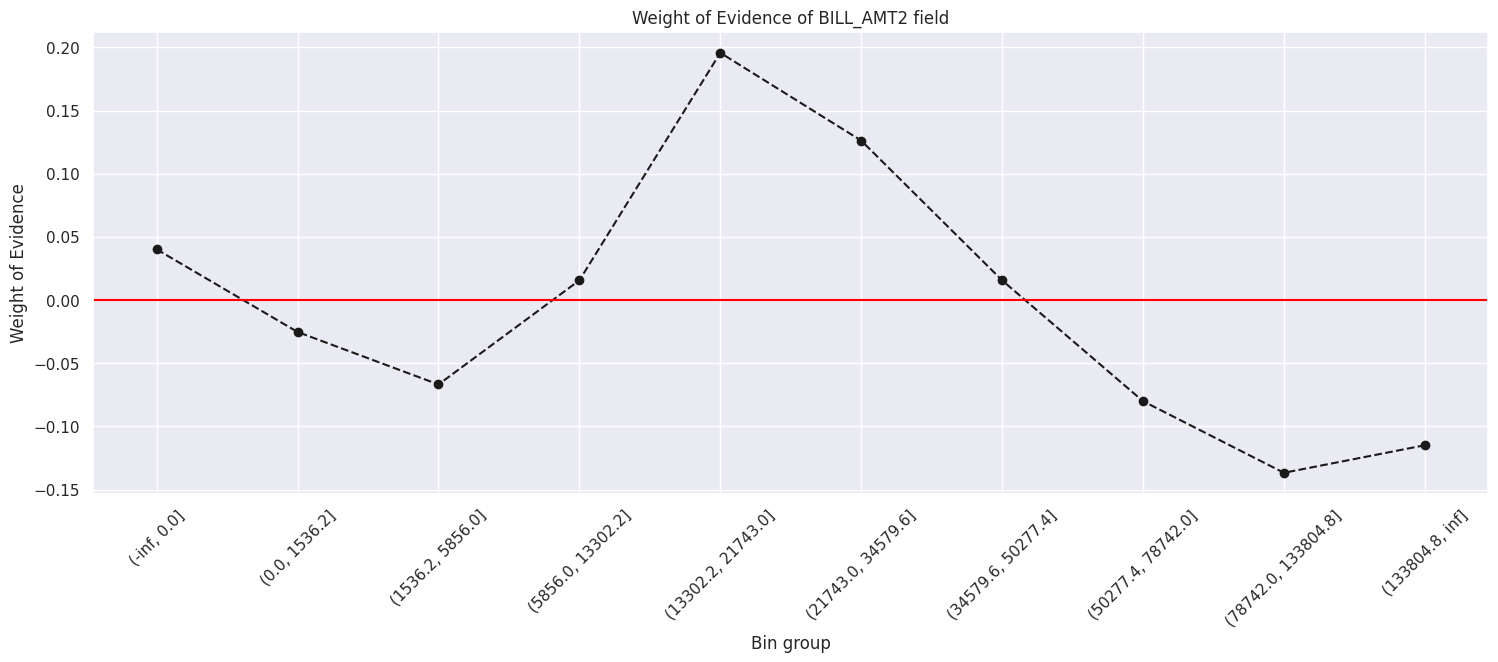

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['BILL_AMT2'] = {'table':df_summary, 'IV':IV}

### BILL_AMT3

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'BILL_AMT3', n_bins = 10)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of BILL_AMT3 column: 0.010570279481861518


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 0.0]",0.000000,2620,0.116450,2015,605,0.300248,0.118907,0.115731,0.027071,0.000086,BILL_AMT3
"(0.0, 1250.6]",1250.600000,1880,0.083559,1443,437,0.302841,0.085888,0.082879,0.035671,0.000107,BILL_AMT3
"(1250.6, 5570.0]",5570.000000,2253,0.100138,1787,466,0.260772,0.091588,0.102636,-0.113891,0.001258,BILL_AMT3
"(5570.0, 12762.0]",12762.000000,2248,0.099916,1757,491,0.279454,0.096502,0.100913,-0.044702,0.000197,BILL_AMT3
"(12762.0, 20245.0]",20245.000000,2250,0.100004,1671,579,0.346499,0.113797,0.095974,0.170342,0.003036,BILL_AMT3
"(20245.0, 31059.8]",31059.800000,2248,0.099916,1682,566,0.336504,0.111242,0.096606,0.141073,0.002065,BILL_AMT3
"(31059.8, 48686.6]",48686.600000,2250,0.100004,1720,530,0.308140,0.104167,0.098788,0.053015,0.000285,BILL_AMT3
"(48686.6, 75322.8]",75322.800000,2250,0.100004,1752,498,0.284247,0.097877,0.100626,-0.027696,0.000076,BILL_AMT3
"(75322.8, 129455.0]",129455.000000,2250,0.100004,1792,458,0.255580,0.090016,0.102923,-0.134001,0.001730,BILL_AMT3


In [ ]:
WOE_dict['BILL_AMT3'] = {'table':df_summary, 'IV':IV}

### BILL_AMT4

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'BILL_AMT4', n_bins = 10)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of BILL_AMT4 column: 0.011485777236758692


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 0.0]",0.000000,2835,0.126006,2183,652,0.298672,0.128145,0.125381,0.021807,0.000060,BILL_AMT4
"(0.0, 1001.8]",1001.800000,1665,0.074003,1274,391,0.306907,0.076847,0.073172,0.049008,0.000180,BILL_AMT4
"(1001.8, 4733.6]",4733.600000,2250,0.100004,1805,445,0.246537,0.087461,0.103670,-0.170024,0.002756,BILL_AMT4
"(4733.6, 11296.2]",11296.200000,2250,0.100004,1778,472,0.265467,0.092767,0.102119,-0.096048,0.000898,BILL_AMT4
"(11296.2, 19050.0]",19050.000000,2250,0.100004,1681,569,0.338489,0.111832,0.096548,0.146954,0.002246,BILL_AMT4
"(19050.0, 28254.0]",28254.000000,2249,0.099960,1682,567,0.337099,0.111439,0.096606,0.142838,0.002119,BILL_AMT4
"(28254.0, 43746.2]",43746.200000,2250,0.100004,1695,555,0.327434,0.109080,0.097352,0.113747,0.001334,BILL_AMT4
"(43746.2, 68631.6]",68631.600000,2250,0.100004,1763,487,0.276234,0.095715,0.101258,-0.056291,0.000312,BILL_AMT4
"(68631.6, 118006.0]",118006.000000,2250,0.100004,1782,468,0.262626,0.091981,0.102349,-0.106806,0.001107,BILL_AMT4


In [ ]:
WOE_dict['BILL_AMT4'] = {'table':df_summary, 'IV':IV}

### BILL_AMT5

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'BILL_AMT5', n_bins = 10)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of BILL_AMT5 column: 0.014951773840974172


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 0.0]",0.000000,3106,0.138051,2363,743,0.314431,0.146030,0.135719,0.073226,0.000755,BILL_AMT5
"(0.0, 773.2]",773.200000,1394,0.061958,1076,318,0.295539,0.062500,0.061800,0.011263,0.000008,BILL_AMT5
"(773.2, 3761.2]",3761.200000,2250,0.100004,1795,455,0.253482,0.089426,0.103096,-0.142246,0.001944,BILL_AMT5
"(3761.2, 10021.2]",10021.200000,2250,0.100004,1815,435,0.239669,0.085495,0.104244,-0.198277,0.003718,BILL_AMT5
"(10021.2, 18258.0]",18258.000000,2250,0.100004,1702,548,0.321974,0.107704,0.097754,0.096933,0.000964,BILL_AMT5
"(18258.0, 26724.2]",26724.200000,2249,0.099960,1661,588,0.354004,0.115566,0.095399,0.191769,0.003867,BILL_AMT5
"(26724.2, 40529.2]",40529.200000,2250,0.100004,1686,564,0.334520,0.110849,0.096835,0.135157,0.001894,BILL_AMT5
"(40529.2, 64405.8]",64405.800000,2250,0.100004,1765,485,0.274788,0.095322,0.101373,-0.061540,0.000372,BILL_AMT5
"(64405.8, 113381.6]",113381.600000,2250,0.100004,1776,474,0.266892,0.093160,0.102004,-0.090694,0.000802,BILL_AMT5


In [ ]:
WOE_dict['BILL_AMT5'] = {'table':df_summary, 'IV':IV}

### BILL_AMT6

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'BILL_AMT6', n_bins = 10)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of BILL_AMT6 column: 0.014924151543331533


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 0.0]",0.000000,3533,0.157029,2717,816,0.300331,0.160377,0.156051,0.027348,0.000118,BILL_AMT6
"(0.0, 468.6]",468.600000,967,0.042980,741,226,0.304993,0.044418,0.042559,0.042752,0.000079,BILL_AMT6
"(468.6, 2700.4]",2700.400000,2250,0.100004,1777,473,0.266179,0.092964,0.102062,-0.093369,0.000849,BILL_AMT6
"(2700.4, 8961.2]",8961.200000,2250,0.100004,1829,421,0.230180,0.082744,0.105049,-0.238674,0.005324,BILL_AMT6
"(8961.2, 17175.0]",17175.000000,2253,0.100138,1737,516,0.297064,0.101415,0.099765,0.016409,0.000027,BILL_AMT6
"(17175.0, 25529.8]",25529.800000,2246,0.099827,1644,602,0.366180,0.118318,0.094423,0.225587,0.005390,BILL_AMT6
"(25529.8, 38487.2]",38487.200000,2250,0.100004,1682,568,0.337693,0.111635,0.096606,0.144600,0.002173,BILL_AMT6
"(38487.2, 61600.4]",61600.400000,2250,0.100004,1751,499,0.284980,0.098074,0.100569,-0.025119,0.000063,BILL_AMT6
"(61600.4, 109699.4]",109699.400000,2250,0.100004,1760,490,0.278409,0.096305,0.101086,-0.048446,0.000232,BILL_AMT6


In [ ]:
WOE_dict['BILL_AMT6'] = {'table':df_summary, 'IV':IV}

### PAY_AMT1

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_AMT1', n_bins = 4)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_AMT1 column: 0.1362410726034311


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 1000.0]",1000.000000,5876,0.261167,4005,1871,0.467166,0.367728,0.230027,0.469147,0.064602,PAY_AMT1
"(1000.0, 2098.0]",2098.000000,5375,0.238900,4141,1234,0.297996,0.242531,0.237838,0.019541,0.000092,PAY_AMT1
"(2098.0, 5000.0]",5000.000000,5724,0.254411,4518,1206,0.266932,0.237028,0.259491,-0.090543,0.002034,PAY_AMT1
"(5000.0, inf]",inf,5524,0.245522,4747,777,0.163682,0.152712,0.272644,-0.579610,0.069514,PAY_AMT1


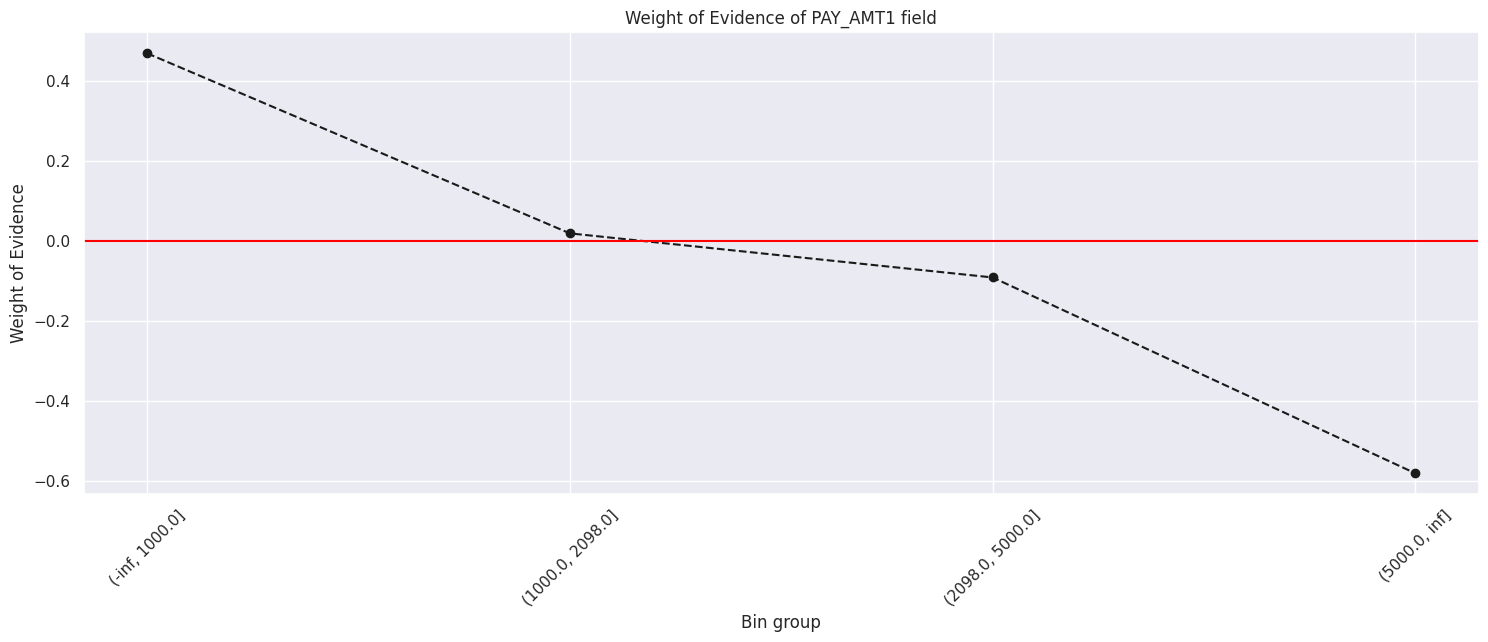

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['PAY_AMT1'] = {'table':df_summary, 'IV':IV}

### PAY_AMT2

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_AMT2', n_bins = 5)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_AMT2 column: 0.12984004611337002


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 211.8]",211.800000,4500,0.200009,3016,1484,0.492042,0.291667,0.173224,0.521027,0.061712,PAY_AMT2
"(211.8, 1534.2]",1534.200000,4500,0.200009,3389,1111,0.327825,0.218357,0.194647,0.114943,0.002725,PAY_AMT2
"(1534.2, 2970.8]",2970.800000,4499,0.199964,3518,981,0.278852,0.192807,0.202056,-0.046858,0.000433,PAY_AMT2
"(2970.8, 5900.0]",5900.000000,4508,0.200364,3620,888,0.245304,0.174528,0.207915,-0.175040,0.005844,PAY_AMT2
"(5900.0, inf]",inf,4492,0.199653,3868,624,0.161324,0.122642,0.222158,-0.594125,0.059125,PAY_AMT2


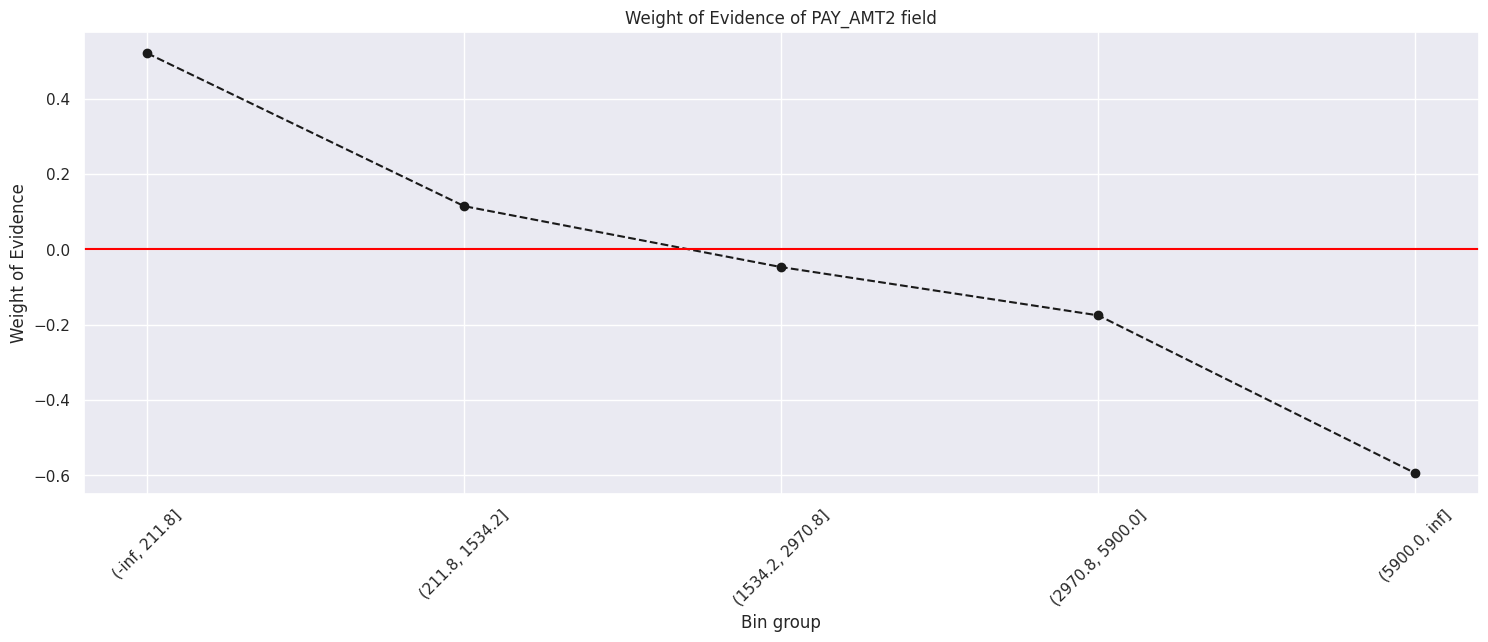

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['PAY_AMT2'] = {'table':df_summary, 'IV':IV}

### PAY_AMT3

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_AMT3', n_bins = 4)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_AMT3 column: 0.08951797347094159


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 367.0]",367.000000,5626,0.250056,3917,1709,0.436303,0.335888,0.224973,0.400800,0.044455,PAY_AMT3
"(367.0, 1676.0]",1676.000000,5625,0.250011,4331,1294,0.298776,0.254324,0.248751,0.022157,0.000123,PAY_AMT3
"(1676.0, 4193.0]",4193.000000,5624,0.249967,4426,1198,0.270673,0.235456,0.254207,-0.076625,0.001437,PAY_AMT3
"(4193.0, inf]",inf,5624,0.249967,4737,887,0.187249,0.174332,0.272069,-0.445097,0.043503,PAY_AMT3


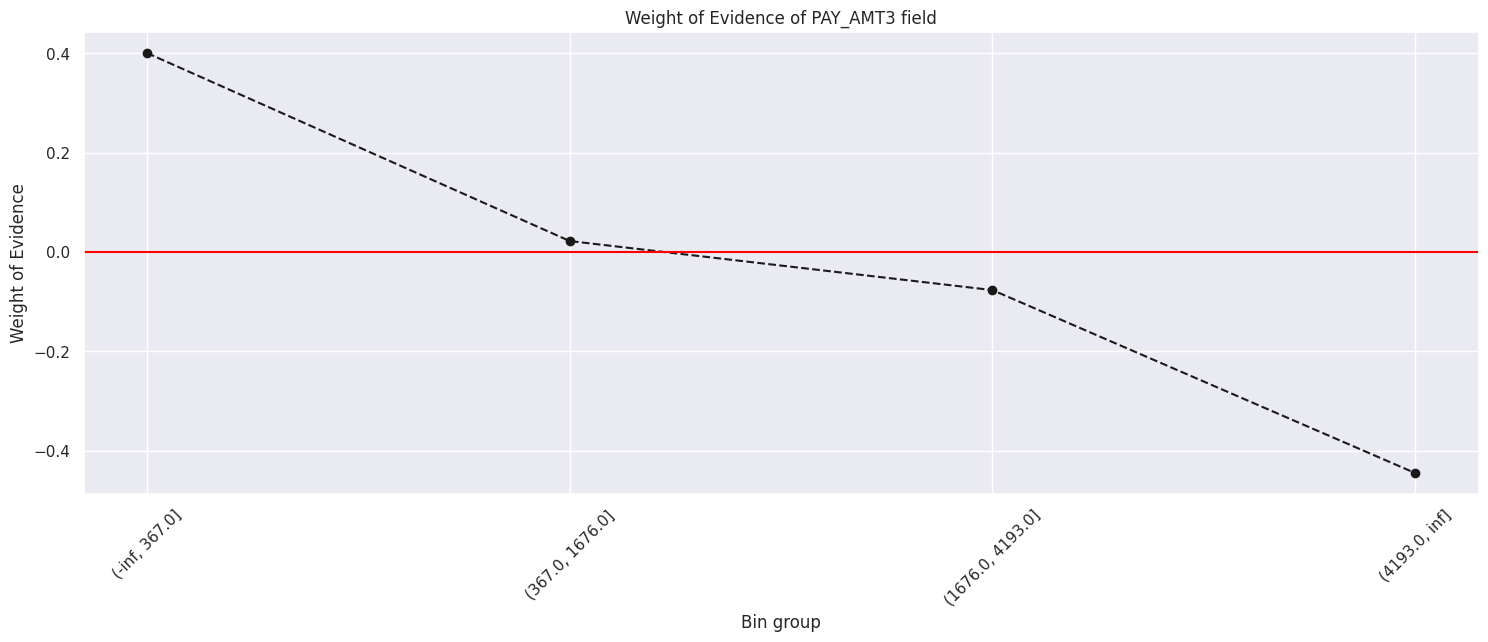

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['PAY_AMT3'] = {'table':df_summary, 'IV':IV}

### PAY_AMT4

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_AMT4', n_bins = 4)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_AMT4 column: 0.09222915352657157


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 270.0]",270.000000,5626,0.250056,3941,1685,0.427556,0.331171,0.226351,0.380548,0.039889,PAY_AMT4
"(270.0, 1500.0]",1500.000000,5911,0.262723,4486,1425,0.317655,0.280071,0.257653,0.083428,0.001870,PAY_AMT4
"(1500.0, 4000.0]",4000.000000,5451,0.242277,4323,1128,0.260930,0.221698,0.248291,-0.113286,0.003013,PAY_AMT4
"(4000.0, inf]",inf,5511,0.244944,4661,850,0.182364,0.167060,0.267704,-0.471532,0.047457,PAY_AMT4


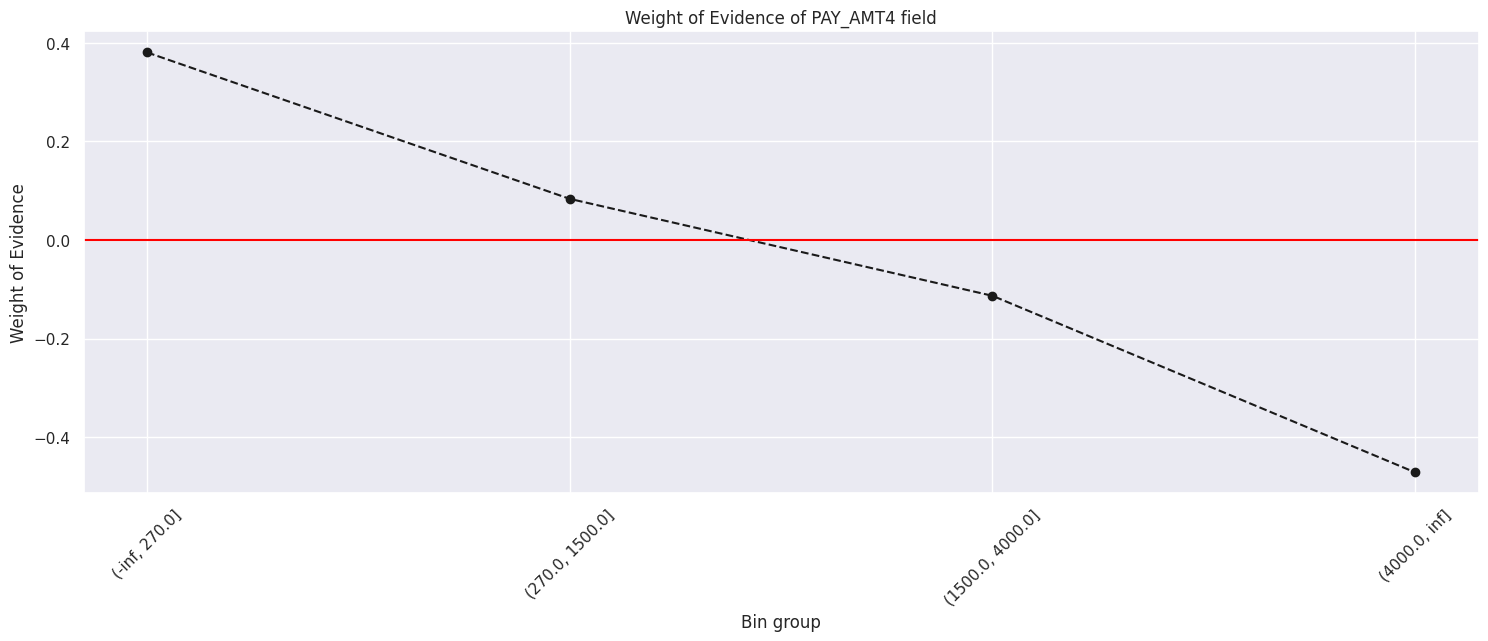

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['PAY_AMT4'] = {'table':df_summary, 'IV':IV}

### PAY_AMT5

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_AMT5', n_bins = 4)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_AMT5 column: 0.07407858537979423


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 247.0]",247.000000,5626,0.250056,3995,1631,0.408260,0.320558,0.229453,0.334367,0.030463,PAY_AMT5
"(247.0, 1500.0]",1500.000000,5764,0.256189,4362,1402,0.321412,0.275550,0.250531,0.095186,0.002381,PAY_AMT5
"(1500.0, 4000.0]",4000.000000,5579,0.247967,4413,1166,0.264219,0.229167,0.253460,-0.100758,0.002448,PAY_AMT5
"(4000.0, inf]",inf,5530,0.245789,4641,889,0.191554,0.174725,0.266556,-0.422371,0.038787,PAY_AMT5


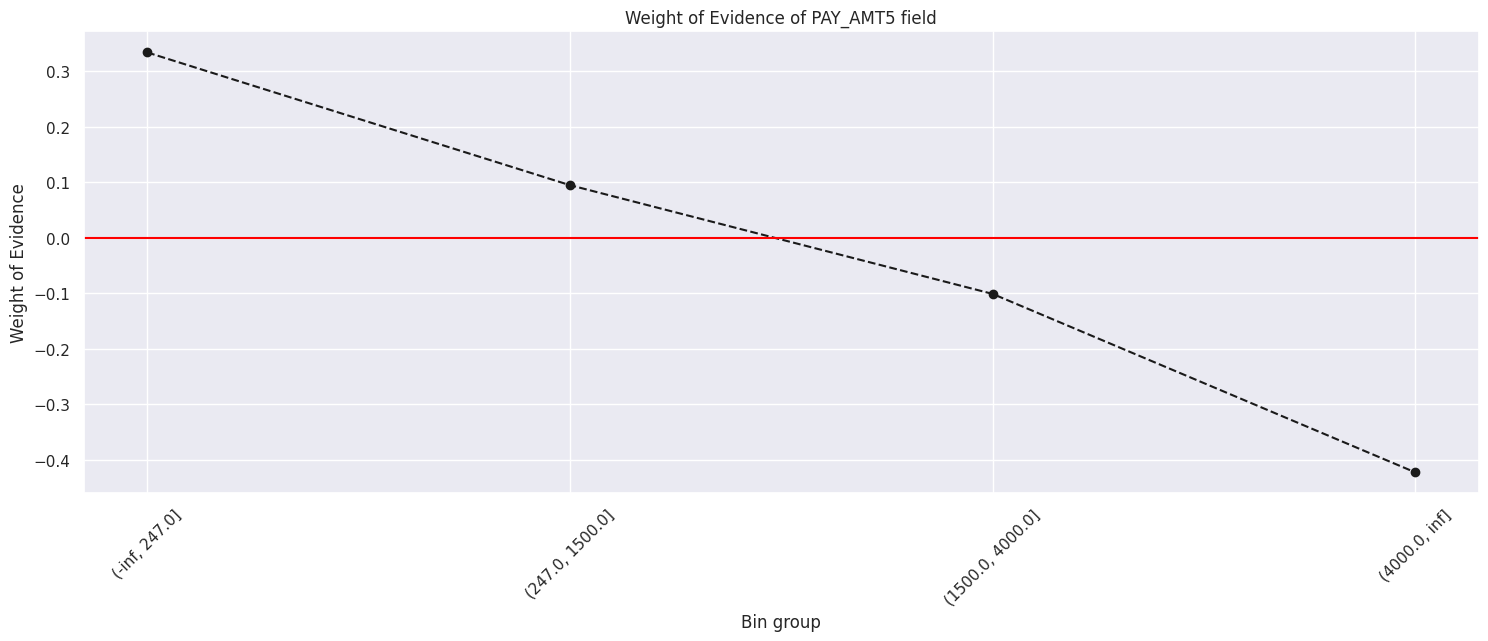

In [ ]:
plot_by_woe(df_summary, 45)

In [ ]:
WOE_dict['PAY_AMT5'] = {'table':df_summary, 'IV':IV}

### PAY_ATM6

In [ ]:
df_summary, IV, thres = _WOE(df_train, 'PAY_AMT6', n_bins = 4)
df_summary.style.bar(subset=['WOE', '%Default'])

1
Information Value of PAY_AMT6 column: 0.08744206228285195


,Thres,No_Obs,%Obs,#Non_Default,#Default,Default/Non_Default,%Default,%Non_Default,WOE,IV,COLUMN
bins,,,,,,,,,,,
"(-inf, 56.0]",56.000000,5627,0.250100,3988,1639,0.410983,0.322131,0.229051,0.341014,0.031742,PAY_AMT6
"(56.0, 1463.0]",1463.000000,5624,0.249967,4260,1364,0.320188,0.268082,0.244673,0.091370,0.002139,PAY_AMT6
"(1463.0, 4000.0]",4000.000000,5808,0.258145,4539,1269,0.279577,0.249410,0.260697,-0.044260,0.000500,PAY_AMT6
"(4000.0, inf]",inf,5440,0.241789,4624,816,0.176471,0.160377,0.265579,-0.504384,0.053062,PAY_AMT6


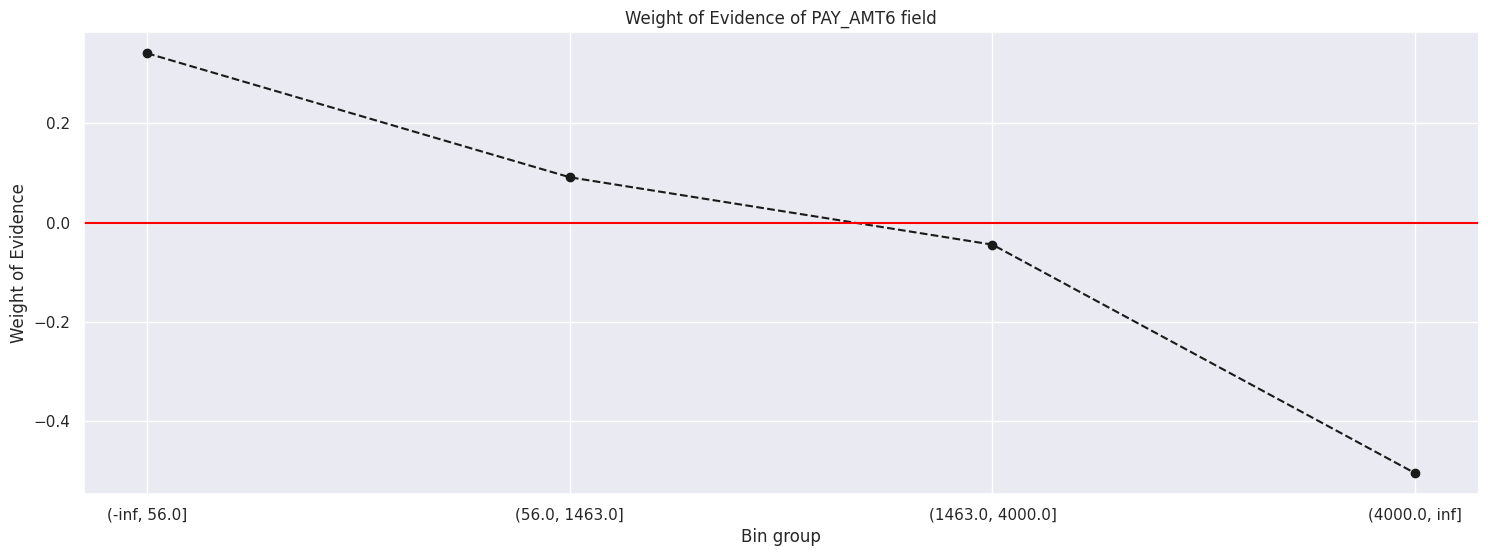

In [ ]:
plot_by_woe(df_summary)

In [ ]:
WOE_dict['PAY_AMT6'] = {'table':df_summary, 'IV':IV}

Có thể thấy các bin đều thỏa mãn yêu cầu **sô lượng quan sát mỗi bin phải trong khoảng 5 - 70%**

## Information Value

Tính Information Value (IV) của từng biến. IV dùng để đo độ tương quan giữa biến độc lập và biến dự đoán (ở dạng binary)

In [ ]:
columns = []
IVs = []
for col in df_train.columns:
    if col not in unused_feat:
        columns.append(col)
        IVs.append(WOE_dict[col]['IV'])
df_iv = pd.DataFrame({'feature': columns, 'IV': IVs})

def _rank_IV(iv):
    if iv <= 0.02:
        return 'Useless'
    elif iv <= 0.1:
        return 'Weak'
    elif iv <= 0.3:
        return 'Medium'
    elif iv <= 0.5:
        return 'Strong'
    else:
        return 'suspicious'

df_iv['rank']=df_iv['IV'].apply(lambda x: _rank_IV(x))
df_iv.sort_values('IV', ascending=False)

,feature,IV,rank
5,PAY_0,0.843180,suspicious
6,PAY_2,0.525181,suspicious
7,PAY_3,0.395270,Strong
8,PAY_4,0.341827,Strong
9,PAY_5,0.332187,Strong
10,PAY_6,0.276759,Medium
0,LIMIT_BAL,0.164079,Medium
17,PAY_AMT1,0.136241,Medium
18,PAY_AMT2,0.129840,Medium
20,PAY_AMT4,0.092229,Weak


Trong thực tế, các biến có IV nhỏ hơn 0.02 sẽ bị loại. Từ đó, 8 biến `SEX`, `MARRIAGE`, `BILL_AMT(1,2,3,4,5,6)` sẽ bị loại.
Có thể thấy `PAY_0`có IV cao nhất. Điều này hợp lí vì biến thể hiện tình trạng thanh toán ở thời điểm gần với thời điểm cần dự đoán nhất

In [ ]:
df_train_woe = df_train.drop(['SEX', 'MARRIAGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis=1)
df_test_woe = df_test.drop(['SEX', 'MARRIAGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis=1)
# df_train = df_train.drop(['SEX', 'MARRIAGE'], axis=1)
# df_test = df_test.drop(['SEX', 'MARRIAGE'], axis=1)

In [ ]:
df_train_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22499 entries, 0 to 22498
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         22499 non-null  int64  
 1   LIMIT_BAL  22499 non-null  float64
 2   EDUCATION  22499 non-null  object 
 3   AGE        22499 non-null  int64  
 4   PAY_0      22499 non-null  object 
 5   PAY_2      22499 non-null  object 
 6   PAY_3      22499 non-null  object 
 7   PAY_4      22499 non-null  object 
 8   PAY_5      22499 non-null  object 
 9   PAY_6      22499 non-null  object 
 10  PAY_AMT1   22499 non-null  float64
 11  PAY_AMT2   22499 non-null  float64
 12  PAY_AMT3   22499 non-null  float64
 13  PAY_AMT4   22499 non-null  float64
 14  PAY_AMT5   22499 non-null  float64
 15  PAY_AMT6   22499 non-null  float64
 16  target     22499 non-null  int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 2.9+ MB


## Feature Encoding

Chọn WoE Encoding, do WoE là thước đo phản ánh độ lớn của tỷ lệ khách hàng tốt/khách hàng xấu trong mỗi nhóm của một biến hay khả năng phân biệt khách hàng tốt/khách hàng xấu của mỗi nhóm

In [ ]:
for col in WOE_dict.keys():
    try:
        key = list(WOE_dict[col]['table']['WOE'].index)
        woe = list(WOE_dict[col]['table']['WOE'])
        d = dict(zip(key, woe))
        # col_woe = col+'_WOE'
        df_train_woe[col] = df_train_woe[col].map(d)
        df_test_woe[col] = df_test_woe[col].map(d)
    except:
        print(col)

SEX
MARRIAGE
BILL_AMT1
BILL_AMT2
BILL_AMT3
BILL_AMT4
BILL_AMT5
BILL_AMT6


In [ ]:
# df_train_woe = df_train.filter(like='_WOE', axis = 1)
# df_test_woe = df_test.filter(like='_WOE', axis = 1)

In [ ]:
# df_train_woe = df_train_woe.join(df_train[['ID', 'target']])
# df_test_woe = df_test_woe.join(df_test[['ID', 'target']])

In [ ]:
df_train_woe.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,0.650015,0.084784,0.260065,2.001081,1.445400,-0.311344,-0.253727,-0.227564,-0.215037,0.469147,0.114943,0.400800,0.380548,0.334367,0.341014,1
1,2,-0.014349,0.084784,-0.101642,-0.575364,1.445400,-0.311344,-0.253727,-0.227564,1.215816,0.469147,0.114943,0.022157,0.083428,0.334367,-0.044260,1
2,3,0.108342,0.084784,-0.044165,-0.575364,-0.378213,-0.311344,-0.253727,-0.227564,-0.215037,0.019541,0.114943,0.022157,0.083428,0.095186,-0.504384,0
3,4,0.254283,0.084784,-0.030417,-0.575364,-0.378213,-0.311344,-0.253727,-0.227564,-0.215037,0.019541,-0.046858,0.022157,0.083428,0.095186,0.091370,0
4,5,0.254283,0.084784,0.150186,-0.575364,-0.378213,-0.311344,-0.253727,-0.227564,-0.215037,0.019541,-0.594125,-0.445097,-0.471532,0.095186,0.091370,0


In [ ]:
df_test_woe.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,22500,-0.693420,0.084784,-0.030417,-0.575364,-0.378213,-0.311344,-0.253727,-0.227564,-0.215037,-0.579610,-0.046858,-0.445097,-0.471532,-0.422371,-0.504384,0
1,22501,-0.274580,0.084784,-0.191593,-0.575364,-0.378213,-0.311344,-0.253727,-0.227564,-0.215037,0.469147,0.114943,-0.445097,-0.113286,-0.100758,-0.044260,0
2,22502,-0.357362,-0.172919,-0.191593,-0.575364,-0.378213,-0.311344,-0.253727,-0.227564,-0.215037,0.019541,-0.046858,-0.076625,-0.113286,-0.100758,-0.044260,0
3,22503,0.254283,0.084784,0.063286,-0.575364,-0.378213,1.271918,1.784323,1.426636,-0.215037,-0.090543,-0.046858,0.400800,0.380548,0.095186,0.091370,1
4,22504,-0.357362,0.084784,-0.191593,-0.575364,-0.378213,-0.311344,-0.253727,-0.227564,-0.215037,-0.579610,-0.594125,-0.445097,-0.471532,-0.422371,-0.504384,1


In [ ]:
# df_test_woe = df_test_woe.dropna()

In [ ]:
# final_df_woe = pd.concat([df_train_woe, df_test_woe])

In [ ]:
# filename = 'CreditScore_save2_woe_transform.pkl'
# pickle.dump(t, open(filename, 'wb'))

### Population Stability Index

In [ ]:
features_list = [feat for feat in df_train_woe.columns if feat not in unused_feat]
psi_df = toad.metrics.PSI(df_train_woe[features_list], df_test_woe[features_list]).sort_values(0)
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})
psi_df

,feature,psi
0,PAY_4,0.001426
1,PAY_2,0.003367
2,PAY_AMT5,0.003660
3,PAY_3,0.003766
4,PAY_AMT1,0.004328
5,PAY_AMT4,0.004401
6,PAY_5,0.005488
7,PAY_0,0.005580
8,PAY_AMT6,0.006482
9,EDUCATION,0.007328


Việc tính PSI của các biến độc lập trong tập train và test để chắc chắn rằng không có sự dịch chuyển phân phối của các biến. Các biến của PSI > 0.25 sẽ bị loại.

##Baseline

### Helper function

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [ ]:
def plot_confusion_matrix(label, predictions):
    cf_matrix = confusion_matrix(label, predictions)
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['Non default', 'Default']
    make_confusion_matrix(cf_matrix,
                      categories=categories,
                      group_names=labels,
                      cbar=False, sum_stats = False, count = True)

In [ ]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

In [ ]:
# def run_baseline_model(model, X_train, y_train, X_test, y_test, verbose=True):
#     t0=time.time()
#     if verbose == False:
#         model.fit(X_train,y_train, verbose=0)
#     else:
#         model.fit(X_train,y_train)

#     # y_pred = model.predict(X_test)

#     pred_train = model.predict_proba(X_train)[:,1]
#     print('train KS', KS(pred_train, y_train))
#     print('train AUC', AUC(pred_train, y_train))

#     pred_test = model.predict_proba(X_test)[:,1]
#     print('Test KS',KS(pred_test, y_test))
#     print('Test AUC',AUC(pred_test, y_test))

In [ ]:
def get_evaluation_score(model, test_df, label):

    predictions = model.predict(test_df)

    accuracy = accuracy_score(label, predictions)
    roc_auc = AUC(model.predict_proba(test_df)[:, 1], label)
    precision = precision_score(label, predictions)
    recall = recall_score(label, predictions)
    f1 = f1_score(label, predictions)

    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Precision  = {}".format(precision))
    print("Recall  = {}".format(recall))
    print("F1 Score  = {}".format(f1))

    print(classification_report(label, predictions))

    plot_confusion_matrix(label, predictions)

### Baseline LR model

In [ ]:
# params_lr = {'penalty': 'l1', 'solver':'liblinear', 'class_weight': 'balanced'}

# model_lr = LogisticRegression(**params_lr)
# run_baseline_model(model = model_lr, X_train = df_train_woe[features_list], y_train= df_train_woe['target'],
#                      X_test = df_test_woe[features_list] , y_test = df_test_woe['target'])

In [ ]:
def run_model(model, train_data, test_data):

    X_train = train_data[features_list]
    y_train = train_data['target']

    X_test  = test_data[features_list]
    y_test  = test_data['target']

    model.fit(X_train, y_train)

    get_evaluation_score(model = model, test_df = X_test, label = y_test)


Accuracy = 0.7930942540994534
ROC Area under Curve = 0.7808787808548532
Precision  = 0.49882903981264637
Recall  = 0.5503875968992248
F1 Score  = 0.5233415233415233
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5953
           1       0.50      0.55      0.52      1548

    accuracy                           0.79      7501
   macro avg       0.69      0.70      0.70      7501
weighted avg       0.80      0.79      0.80      7501



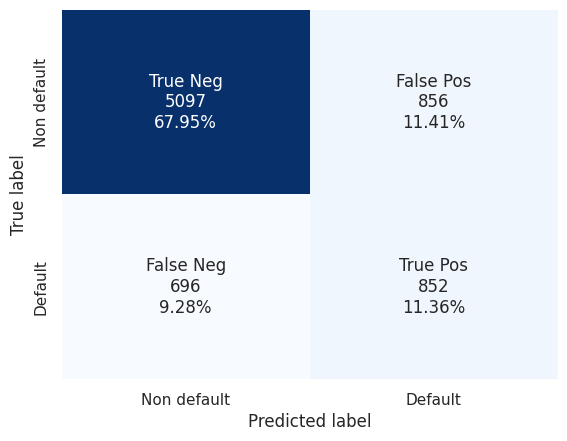

In [ ]:
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear', 'class_weight': 'balanced'}

model_lr = LogisticRegression(**params_lr)
run_model(model = model_lr, train_data = df_train_woe, test_data = df_test_woe)

**Note**: Do dữ liệu không cân bằng nên sử dụng **'class_weight': 'balanced'** để tăng khả năng đoán đúng các nhãn default

# Tree-based models

In [ ]:
for col in CATEGORICAL_COLS:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    df_train_tree[col] = l_enc.fit_transform(df_train_tree[col].values.astype(str))
    df_test_tree[col] = l_enc.fit_transform(df_test_tree[col].values.astype(str))

SEX 2
EDUCATION 4
MARRIAGE 3
PAY_0 4
PAY_2 3
PAY_3 3
PAY_4 3
PAY_5 3
PAY_6 3


In [ ]:
df_train_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22499 entries, 0 to 22498
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         22499 non-null  int64  
 1   LIMIT_BAL  22499 non-null  float64
 2   SEX        22499 non-null  int64  
 3   EDUCATION  22499 non-null  int64  
 4   MARRIAGE   22499 non-null  int64  
 5   AGE        22499 non-null  int64  
 6   PAY_0      22499 non-null  int64  
 7   PAY_2      22499 non-null  int64  
 8   PAY_3      22499 non-null  int64  
 9   PAY_4      22499 non-null  int64  
 10  PAY_5      22499 non-null  int64  
 11  PAY_6      22499 non-null  int64  
 12  BILL_AMT1  22499 non-null  float64
 13  BILL_AMT2  22499 non-null  float64
 14  BILL_AMT3  22499 non-null  float64
 15  BILL_AMT4  22499 non-null  float64
 16  BILL_AMT5  22499 non-null  float64
 17  BILL_AMT6  22499 non-null  float64
 18  PAY_AMT1   22499 non-null  float64
 19  PAY_AMT2   22499 non-null  float64
 20  PAY_AM

##Random Forest

Accuracy = 0.8218904146113851
ROC Area under Curve = 0.7728364002081767
Precision  = 0.5949820788530465
Recall  = 0.4289405684754522
F1 Score  = 0.4984984984984984
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      5953
           1       0.59      0.43      0.50      1548

    accuracy                           0.82      7501
   macro avg       0.73      0.68      0.70      7501
weighted avg       0.81      0.82      0.81      7501



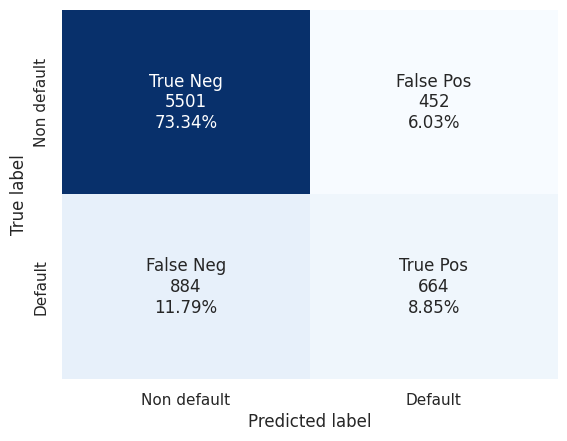

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345,
             'class_weight': 'balanced'
             }

model_rf = RandomForestClassifier(**params_rf)
run_model(model = model_rf, train_data = df_train_tree, test_data = df_test_tree)

##AdaBoost

Accuracy = 0.7816291161178509
ROC Area under Curve = 0.7753423566429711
Precision  = 0.4769467213114754
Recall  = 0.601421188630491
F1 Score  = 0.5320000000000001
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5953
           1       0.48      0.60      0.53      1548

    accuracy                           0.78      7501
   macro avg       0.68      0.71      0.69      7501
weighted avg       0.80      0.78      0.79      7501



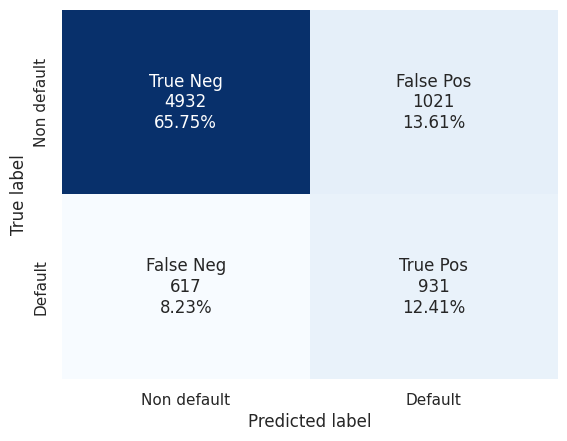

In [ ]:
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, class_weight = 'balanced'),
                                  n_estimators=50,
                                  algorithm="SAMME.R",
                                  learning_rate=0.5
                                  )
run_model(model = model_ada, train_data = df_train_tree, test_data = df_test_tree)

##CatBoost

Learning rate set to 0.5
0:	learn: 0.5293706	total: 91ms	remaining: 4.46s
1:	learn: 0.4738182	total: 101ms	remaining: 2.42s
2:	learn: 0.4498922	total: 133ms	remaining: 2.09s
3:	learn: 0.4392651	total: 163ms	remaining: 1.87s
4:	learn: 0.4327365	total: 193ms	remaining: 1.74s
5:	learn: 0.4281708	total: 225ms	remaining: 1.65s
6:	learn: 0.4252546	total: 251ms	remaining: 1.54s
7:	learn: 0.4235900	total: 278ms	remaining: 1.46s
8:	learn: 0.4209576	total: 305ms	remaining: 1.39s
9:	learn: 0.4192490	total: 333ms	remaining: 1.33s
10:	learn: 0.4180791	total: 359ms	remaining: 1.27s
11:	learn: 0.4169002	total: 386ms	remaining: 1.22s
12:	learn: 0.4152112	total: 418ms	remaining: 1.19s
13:	learn: 0.4127291	total: 448ms	remaining: 1.15s
14:	learn: 0.4105927	total: 475ms	remaining: 1.11s
15:	learn: 0.4097011	total: 503ms	remaining: 1.07s
16:	learn: 0.4075564	total: 530ms	remaining: 1.03s
17:	learn: 0.4053026	total: 558ms	remaining: 992ms
18:	learn: 0.4031152	total: 585ms	remaining: 955ms
19:	learn: 0.4017

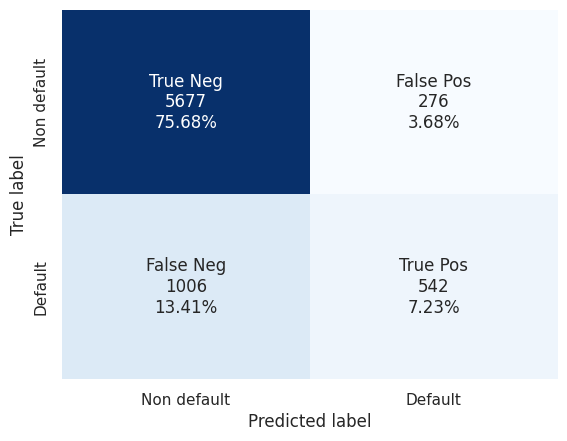

In [ ]:
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 10
            }

model_cb = cb.CatBoostClassifier(**params_cb)
run_model(model = model_cb, train_data = df_train_tree, test_data = df_test_tree)

##LightGBM

[LightGBM] [Info] Number of positive: 5088, number of negative: 17411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 22499, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226143 -> initscore=-1.230217
[LightGBM] [Info] Start training from score -1.230217
Accuracy = 0.8373550193307558
ROC Area under Curve = 0.787118713297228
Precision  = 0.7118863049095607
Recall  = 0.35594315245478036
F1 Score  = 0.47459086993970706
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5953
           1       0.71      0.36      0.47      1548

    accuracy                           0.84      7501
   macro avg       0.78      0.66      0.69      7501
weighte

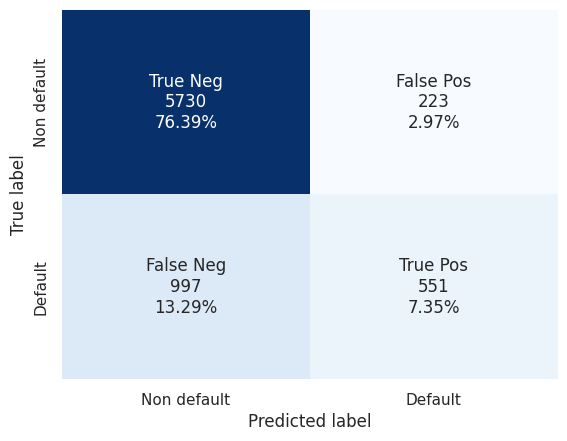

In [ ]:
import lightgbm as lgb
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,
          'max_depth': 4,
          'min_child_samples': 100,
          'max_bin': 100,
          'subsample': 0.9,
          'subsample_freq': 1,
          'colsample_bytree': 0.7
         }
model_lgb = lgb.LGBMClassifier(**params)
run_model(model = model_lgb, train_data = df_train_tree, test_data = df_test_tree)

##XGB

Accuracy = 0.8265564591387815
ROC Area under Curve = 0.7642669580968232
Precision  = 0.6493349455864571
Recall  = 0.34689922480620156
F1 Score  = 0.4522105263157895
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      5953
           1       0.65      0.35      0.45      1548

    accuracy                           0.83      7501
   macro avg       0.75      0.65      0.67      7501
weighted avg       0.81      0.83      0.81      7501



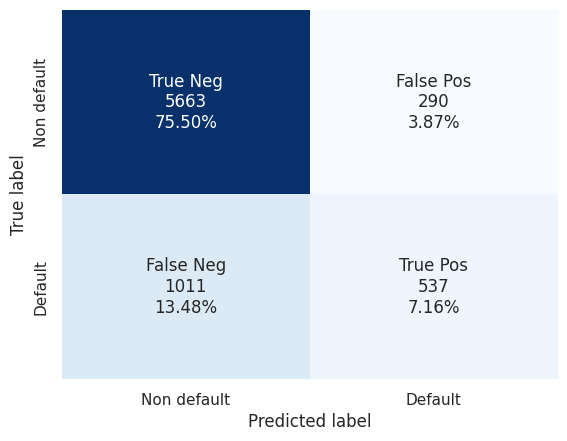

In [ ]:
import xgboost as xgb
params_xgb ={
    'booster': 'dart',
    'objective':'binary:logistic',
    'eta':0.1,
    'silent':True,
    'max_depth':8,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'eval_metric':'auc',
    'random_state': 42,
    'n_estimators': 200
    }

model_xgb = xgb.XGBClassifier(**params_xgb)
run_model(model = model_xgb, train_data = df_train_tree, test_data = df_test_tree)

Từ đó ta có bảng tổng kết hiệu suất của các mô hình

| Model  | AUC   | Type II  |  
|:---:|:---:|:---:|
| Logistic Regression + WOE | 0.7805 | 9.27  |   
| Random Forest  | 0.7729  | 11.79  |   
| AdaBoost   |  0.7753 |  **8.23** |   
| CatBoost   | 0.7696  | 13.41  |   
| LightGBM   |  **0.7871** | 13.29  |   
| XGBoost   |  0.7643 | 13.48  |   

* Với bài toán Behavior Scoring, chúng ta nên chú trọng vào việc giảm số lượng sai lầm loại II (FN) mà mô hình phán đoán được. Những khách hàng thuộc sai lầm loại II về thực tế họ đã chưa thanh toán nhưng mô hình dự đoán những khách hàng này đã thanh toán theo đúng kỳ hạn. Xét theo góc độ tín dụng, nếu KH trả lãi không đủ và đúng hạn thì điểm tín dụng của KH sẽ thấp, nhảy nhóm nợ trên hệ thống tin tín dụng quốc gia CIC, điều này sẽ gây khó khăn cho các khoản vay tiếp theo của KH vì để có một CIC đẹp là người đã từng vay và trả lãi đúng hạn nên sai lầm loại II (FN) có tính chất nghiêm trọng hơn. Do đó,  ngoài việc lựa chọn mô hình tốt, chúng ta cũng cần lựa chọn những mô hình có các TH thuộc sai lầm loại II là thấp nhất.
* Dựa vào đồ thị trên kết hợp với confusion matrix của các mô hình đã huấn luyện ở trên thì mô hình LightGBM cho AUC tốt nhất 78.71%  và mô hình AdaBoost có số lượng sai lầm loại II thấp nhất 8.23%. Ở đây chúng ta sẽ thấy mô hình Logistic Regression có AUC và Type II gần như không kém 2 mô hình trên quá nhiều mà có rất nhiều ưu điểm như mô hình rất dễ giải thích và đơn giản để có thể huấn luyện, kiểm thử, tinh chỉnh trong thời gian ngắn, do đó chọn mô hình Logistic Regression làm mô hình cuối cùng để áp dụng vào bài toán này!

# Scorecard Pipeline

In [ ]:
df_infer = df.copy()

In [ ]:
def _CreditScore(beta, alpha, woe, n = 12, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

_CreditScore(beta = 0.5, alpha = -1, woe = 0.15, n = 12)

42.2677896003704

In [ ]:
betas_dict = dict(zip(list(df_train[features_list]), model_lr.coef_[0]))
alpha = model_lr.intercept_[0]
betas_dict

{'LIMIT_BAL': 0.27137354910031114,
 'EDUCATION': 0.40784764189088896,
 'AGE': 0.375342912751213,
 'PAY_0': 0.7329844243354378,
 'PAY_2': 0.07662194606560464,
 'PAY_3': 0.21460713722921937,
 'PAY_4': 0.10504386739865625,
 'PAY_5': 0.20451844809280464,
 'PAY_6': 0.20350899141884907,
 'PAY_AMT1': 0.2756342702560078,
 'PAY_AMT2': 0.17222439219691832,
 'PAY_AMT3': 0.24783760950174924,
 'PAY_AMT4': 0.2223928659465232,
 'PAY_AMT5': 0.05400360064657829,
 'PAY_AMT6': 0.09563144952376848}

In [ ]:
cols = []
features = []
woes = []
betas = []
scores = []

for col in features_list:
    for feature, woe in WOE_dict[col]['table']['WOE'].to_frame().iterrows():
        cols.append(col)
        # Add feature
        feature = str(feature)
        features.append(feature)
        # Add woe
        woe = woe.values[0]
        woes.append(woe)
        # Add beta
        # col_woe = col+'_WOE'
        beta = betas_dict[col]
        betas.append(beta)
        # Add score
        score = _CreditScore(beta = beta, alpha = alpha, woe = woe, n = 15, odds = 1/4, pdo = -100, thres_score = 750)
        scores.append(score)

score_card_df = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas':betas, 'Scores':scores})
score_card_df.head(30)

,Columns,Features,WOE,Betas,Scores
0,LIMIT_BAL,"(-inf, 30000.0]",0.650015,0.271374,11.145845
1,LIMIT_BAL,"(30000.0, 50000.0]",0.254283,0.271374,26.639137
2,LIMIT_BAL,"(50000.0, 70000.0]",0.346262,0.271374,23.038069
3,LIMIT_BAL,"(70000.0, 100000.0]",0.108342,0.271374,32.352861
4,LIMIT_BAL,"(100000.0, 130000.0]",-0.014349,0.271374,37.156318
5,LIMIT_BAL,"(130000.0, 170000.0]",-0.250218,0.271374,46.390825
6,LIMIT_BAL,"(170000.0, 210000.0]",-0.274580,0.271374,47.344598
7,LIMIT_BAL,"(210000.0, 260000.0]",-0.357362,0.271374,50.585592
8,LIMIT_BAL,"(260000.0, 360000.0]",-0.464527,0.271374,54.781223
9,LIMIT_BAL,"(360000.0, inf]",-0.693420,0.271374,63.742590


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         7501 non-null   int64  
 1   LIMIT_BAL  7501 non-null   float64
 2   SEX        7501 non-null   object 
 3   EDUCATION  7501 non-null   object 
 4   MARRIAGE   7501 non-null   object 
 5   AGE        7501 non-null   int64  
 6   PAY_0      7501 non-null   object 
 7   PAY_2      7501 non-null   object 
 8   PAY_3      7501 non-null   object 
 9   PAY_4      7501 non-null   object 
 10  PAY_5      7501 non-null   object 
 11  PAY_6      7501 non-null   object 
 12  BILL_AMT1  7501 non-null   float64
 13  BILL_AMT2  7501 non-null   float64
 14  BILL_AMT3  7501 non-null   float64
 15  BILL_AMT4  7501 non-null   float64
 16  BILL_AMT5  7501 non-null   float64
 17  BILL_AMT6  7501 non-null   float64
 18  PAY_AMT1   7501 non-null   float64
 19  PAY_AMT2   7501 non-null   float64
 20  PAY_AMT3

In [ ]:
test_obs = df_test[columns].iloc[0:1, :]
test_obs

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,420000.0,2,2,1,37,0,0,0,0,0,...,9778.0,158901.0,161876.0,165378.0,7022.0,1846.0,163862.0,6000.0,6000.0,6000.0


In [ ]:
def _search_score(obs, col):
    if obs[col].dtype == 'object':
        feature = [str(inter) for inter in list(WOE_dict[col]['table'].index) if obs[col].values[0] == inter][0]
    else:
        feature = [str(inter) for inter in list(WOE_dict[col]['table'].index) if obs[col].values[0] in inter][0]
    score = score_card_df[(score_card_df['Columns'] == col) & (score_card_df['Features'] == feature)]['Scores'].values[0]
    return score

# Tính điểm cho trường 'LIMIT_BAL' của bộ hồ sơ test
score = _search_score(test_obs, 'LIMIT_BAL')
score

63.74258959609668

In [ ]:
def _total_score(obs, columns = columns):
    scores = dict()
    for col in columns:
        scores[col] = _search_score(obs, col)
    total_score = sum(scores.values())
    return scores, total_score

scores, total_score = _total_score(test_obs, features_list)
print('score for each fields: \n', scores)
print('final total score: ', total_score)

score for each fields: 
 {'LIMIT_BAL': 63.74258959609668, 'EDUCATION': 31.60586118509491, 'AGE': 38.241659545091345, 'PAY_0': 97.43769474887125, 'PAY_2': 40.77539851385551, 'PAY_3': 46.234155370954014, 'PAY_4': 40.43967902876273, 'PAY_5': 43.30900842502545, 'PAY_6': 42.90806912631183, 'PAY_AMT1': 59.6431144800835, 'PAY_AMT2': 37.75881819812352, 'PAY_AMT3': 52.50917143834539, 'PAY_AMT4': 51.723406774671346, 'PAY_AMT5': 39.88526728662232, 'PAY_AMT6': 43.553379091724544}
final total score:  729.7672728096344


In [ ]:
def calculate_credit_score(data, feat):
  total_scores = []

  for i in np.arange(data[feat].shape[0]):
      obs = data[feat].iloc[i:(i+1), :]
      _, score = _total_score(obs, feat)
      total_scores.append(score)

  return total_scores

In [ ]:
df_test['CreditScore'] = calculate_credit_score(df_test, features_list)
df_test['CreditScore'].describe()

count    7501.000000
mean      596.370954
std       139.862065
min        13.160465
25%       568.195300
50%       632.295157
75%       685.713258
max       840.604672
Name: CreditScore, dtype: float64

In [ ]:
df['CreditScore'] = calculate_credit_score(df, features_list)
df['CreditScore'].describe()

count    30000.000000
mean       583.461300
std        146.164098
min          1.766672
25%        543.238687
50%        625.310035
75%        676.795764
max        840.604672
Name: CreditScore, dtype: float64

Tới đây ta đã có bảng tiêu chí chấm điểm tín dụng cho từng khách hàng

In [ ]:
score_card_df.to_csv('CreditScore_save6_score_card_df.csv',index=False)

## Distribution Analysis

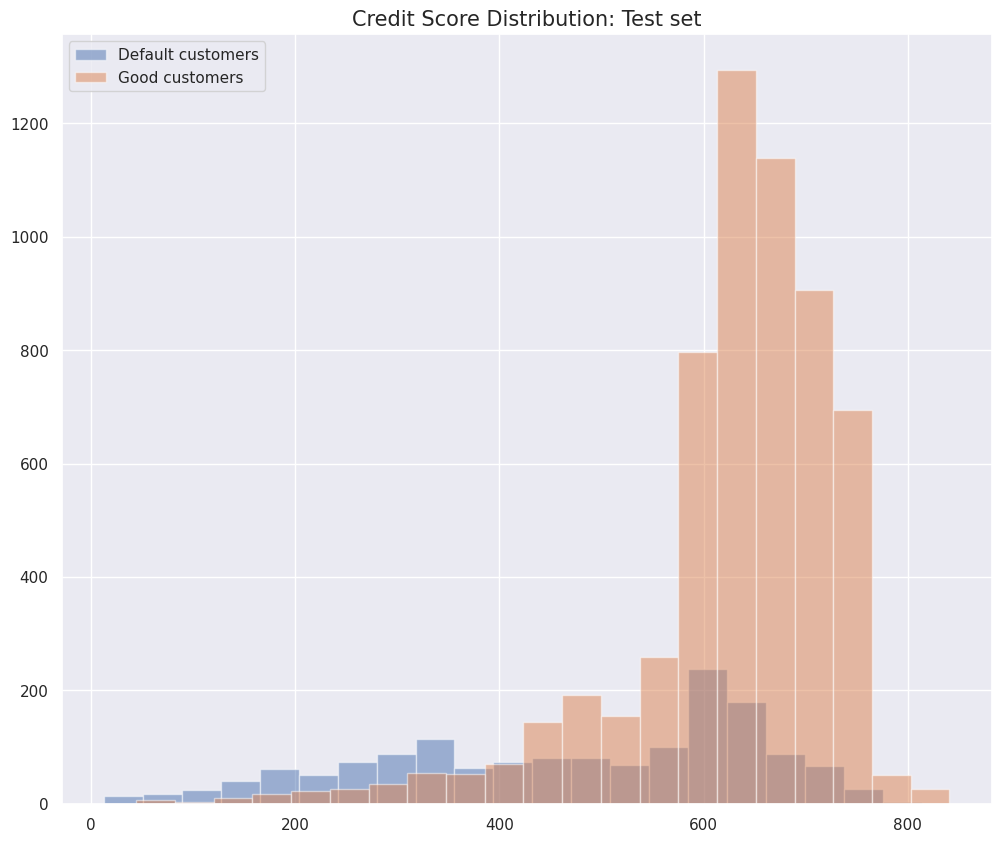

In [ ]:
plt.figure(figsize=(12,10))

w = 40
n = math.ceil((df_test['CreditScore'].max() - df_test['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(df_test[df_test.target==1].CreditScore, alpha=0.5, label='Default customers',bins = n)
plt.hist(df_test[df_test.target==0].CreditScore, alpha=0.5, label='Good customers',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test set',size=15)
plt.show()

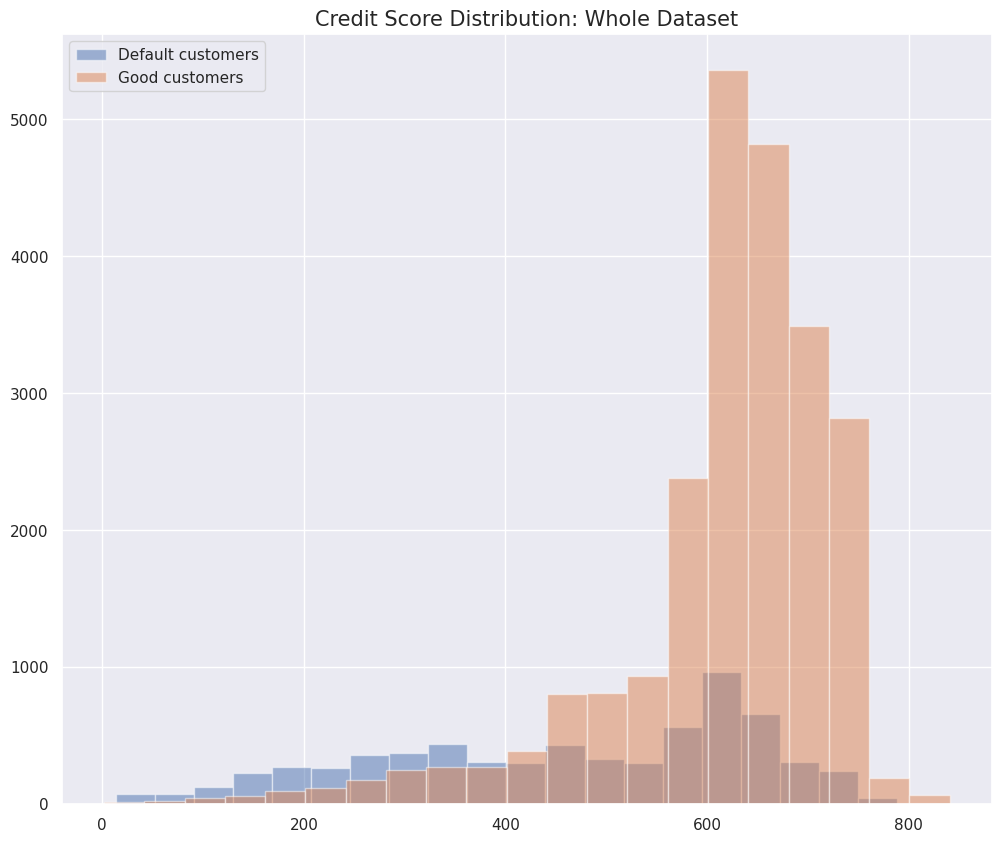

In [ ]:
plt.figure(figsize=(12,10))

import math

w = 40
n = math.ceil((df['CreditScore'].max() - df['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(df[df.target==1].CreditScore, alpha=0.5, label='Default customers',bins = n)
plt.hist(df[df.target==0].CreditScore, alpha=0.5, label='Good customers',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Whole Dataset',size=15)
plt.show()

Đỉnh của phân phối của Good customer sẽ có xu hướng dịch về phải và Default customer sẽ dịch về trái. 2 phân phối này càng có sự phân cực rõ ràng thì scorecard phân hóa khách hàng càng hiệu quả.

## Threshold Tuning & Trade-off between loss & Coverage

Mục tiêu là chia các khách hàng thành 8 nhóm khác nhau tương đương với
 8 khoảng điểm tín dụng khác nhau, từ Blacklist đến Perfect Credt.

In [ ]:
obj_df = pd.DataFrame(
    {'Credit Level': ['Level 0', 'Level 1', 'Level 2','Level 3','Level 4','Level 5','Level 6','Level 7','Level 8'],
     'Description': ['Blacklist', 'High Risk', 'Medium Risk','Moderate Risk','Low Risk','Normal Credit','Good Credit','Excellent Credit','Prefect Credit']
     }
)

obj_df

,Credit Level,Description
0,Level 0,Blacklist
1,Level 1,High Risk
2,Level 2,Medium Risk
3,Level 3,Moderate Risk
4,Level 4,Low Risk
5,Level 5,Normal Credit
6,Level 6,Good Credit
7,Level 7,Excellent Credit
8,Level 8,Prefect Credit


Từ đây chúng ta sẽ tinh chỉnh từng khoảng điểm tín dụng cho phù hợp nhất với mỗi nhóm

In [ ]:
def get_credit_level(
    test,
    target_score ='order_score',
    out_col = 'order_level',
    left_bound = -100,
    level_0 = 100,
    level_1 = 200,
    level_2 = 250,
    level_3 = 300,
    level_4 = 350,
    level_5 = 400,
    level_6 = 450,
    level_7 = 500,
    level_8 = 800
    ):

    level = []
    for i in range(len(test)):
        if (test[target_score][i]>left_bound) & (test[target_score][i]<=level_0):
            level.append(0)
        elif  (test[target_score][i]>level_0) & (test[target_score][i]<=level_1):
            level.append(1)
        elif  (test[target_score][i]>level_1) & (test[target_score][i]<=level_2):
            level.append(2)
        elif  (test[target_score][i]>level_2) & (test[target_score][i]<=level_3):
            level.append(3)
        elif  (test[target_score][i]>level_3) & (test[target_score][i]<=level_4):
            level.append(4)
        elif  (test[target_score][i]>level_4) & (test[target_score][i]<=level_5):
            level.append(5)
        elif  (test[target_score][i]>level_5) & (test[target_score][i]<=level_6):
            level.append(6)
        elif  (test[target_score][i]>level_6) & (test[target_score][i]<=level_7):
            level.append(7)
        elif  (test[target_score][i]>level_7 )& (test[target_score][i]<=level_8):
            level.append(8)

    test[out_col] = level
    return test

In [ ]:
df_test.CreditScore.describe()

count    7501.000000
mean      596.370954
std       139.862065
min        13.160465
25%       568.195300
50%       632.295157
75%       685.713258
max       840.604672
Name: CreditScore, dtype: float64

In [ ]:
df_test = get_credit_level(df_test,
                       target_score ='CreditScore',
                       out_col = 'CreditScore_level',
                       left_bound = -1000,
                       level_0 = 250,
                       level_1 = 300,
                       level_2 = 400,
                       level_3 = 500,
                       level_4 = 580,
                       level_5 = 630,
                       level_6 = 690,
                       level_7 = 730,
                       level_8 = 850
                       )

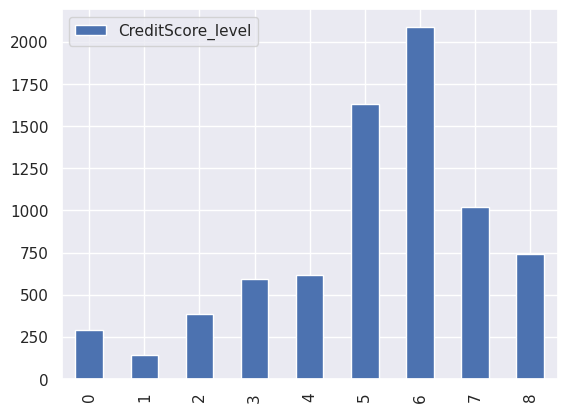

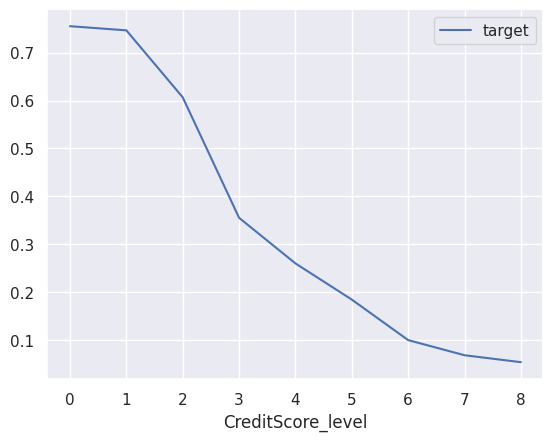

In [ ]:
def plot_bts_level_loss(test, target_col):
    bts_level_df = test[target_col].value_counts()
    bts_level_df=pd.DataFrame(bts_level_df)
    df_label_level= test[test.target==1].groupby(target_col)['target'].count()/ test.groupby(target_col)['target'].count()
    df_label_level = pd.DataFrame(df_label_level)
    bts_level_df.sort_index().plot.bar(title='')
    df_label_level.plot()

plot_bts_level_loss(df_test,target_col='CreditScore_level')

Biểu đồ 1 biểu thị số lượng quan sát của từng nhóm khách hàng, biểu đồ 2 biểu thị tỷ lệ vỡ nợ của từng nhóm

In [ ]:
def get_loss_coverage(test,target_level):

    #level 8 Loss
    L8_loss=test[test[target_level]>=8 ].target.value_counts()/len(test[test[target_level]>=8 ])
    #level 8 Coverage
    L8_coverage=test[test[target_level]>=8].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 8: Loss is ",L8_loss[1], "; Coverage is ",L8_coverage)

    #level 7-level 8 Loss
    L7_loss=test[test[target_level]>=7 ].target.value_counts()/len(test[test[target_level]>=7 ])
    #level 7-level 8 Coverage
    L7_coverage=test[test[target_level]>=7].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 7-Level 8: Loss is ",L7_loss[1], "; Coverage is ",L7_coverage)

    #level 6-level 8 Loss
    L6_loss=test[test[target_level]>=6 ].target.value_counts()/len(test[test[target_level]>=6 ])
    #level 6-level 8 Coverage
    L6_coverage=test[test[target_level]>=6].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 6-Level 8: Loss is ",L6_loss[1], "; Coverage is ",L6_coverage)

     #level 5-Leve 8 Loss (percentage of default people)
    L5_loss = test[test[target_level]>=5 ].target.value_counts()/len(test[test[target_level]>=5 ])
    #level 5- level 8 Coverage (percentage of good people)
    L5_coverage=test[test[target_level]>=5 ].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 5-Level 8: Loss is ",L5_loss[1], "; Coverage is ",L5_coverage)

    #level 4-level 8 Loss
    L4_loss=test[test[target_level]>=4 ].target.value_counts()/len(test[test[target_level]>=4 ])
    #level 4-level 8 Coverage
    L4_coverage=test[test[target_level]>=4].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 4-Level 8: Loss is ",L4_loss[1], "; Coverage is ",L4_coverage)


    #level 3-level 8 Loss
    L3_loss=test[test[target_level]>=3].target.value_counts()/len(test[test[target_level]>=3 ])
    #level 3-level 8 Coverage
    L3_coverage=test[test[target_level]>=3].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 3-Level 8: Loss is ",L3_loss[1], "; Coverage is ",L3_coverage)

    #level 2-level 8 Loss
    L2_loss=test[test[target_level]>=2].target.value_counts()/len(test[test[target_level]>=2 ])
    #level 2-level 8 Coverage
    L2_coverage=test[test[target_level]>=2].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 2-Level 8: Loss is ",L2_loss[1], "; Coverage is ",L2_coverage)

    #level 1-level 8 Loss
    L1_loss=test[test[target_level]>=1].target.value_counts()/len(test[test[target_level]>=1 ])
    #level 1-level 8 Coverage
    L1_coverage=test[test[target_level]>=1].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 1-Level 8: Loss is ",L1_loss[1], "; Coverage is ",L1_coverage)

    #level 0-level 8 Loss
    L0_loss=test[test[target_level]>=0].target.value_counts()/len(test[test[target_level]>=0 ])
    #level 0-level 8 Coverage
    L0_coverage=test[test[target_level]>=0].target.value_counts()[0]/test[test.target==0].shape[0]
    print("Level 0-Level 8: Loss is ",L0_loss[1], "; Coverage is ",L0_coverage)

In [ ]:
get_loss_coverage(df_test,target_level='CreditScore_level')

Level 8: Loss is  0.05405405405405406 ; Coverage is  0.11758777087182933
Level 7-Level 8: Loss is  0.06246450880181715 ; Coverage is  0.2773391567277003
Level 6-Level 8: Loss is  0.08287866978435958 ; Coverage is  0.5929783302536537
Level 5-Level 8: Loss is  0.11315933564519073 ; Coverage is  0.8162271123803124
Level 4-Level 8: Loss is  0.1279947489333771 ; Coverage is  0.8926591634470015
Level 3-Level 8: Loss is  0.1480927449513837 ; Coverage is  0.9566605073072401
Level 2-Level 8: Loss is  0.17300891215164804 ; Coverage is  0.9820258693095918
Level 1-Level 8: Loss is  0.18430176119816946 ; Coverage is  0.9880732403830002
Level 0-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0


In [ ]:
obj_df = pd.DataFrame(
    {'Credit Level': ['Level 0', 'Level 1', 'Level 2','Level 3','Level 4','Level 5','Level 6','Level 7','Level 8'],
     'Description': ['Blacklist', 'High Risk', 'Medium Risk','Moderate Risk','Low Risk','Normal Credit','Good Credit','Excellent Credit','Prefect Credit'],
     'Scores Range': ['0-250', '250-300', '300-400', '400-500', '500-580', '580-630', '630-690', '690-730', '730-800']
     }
)

obj_df

,Credit Level,Description,Scores Range
0,Level 0,Blacklist,0-250
1,Level 1,High Risk,250-300
2,Level 2,Medium Risk,300-400
3,Level 3,Moderate Risk,400-500
4,Level 4,Low Risk,500-580
5,Level 5,Normal Credit,580-630
6,Level 6,Good Credit,630-690
7,Level 7,Excellent Credit,690-730
8,Level 8,Prefect Credit,730-800


In [ ]:
obj_df['Customers'] = df_test['CreditScore_level'].value_counts().sort_index().tolist()
obj_df['Customer Rate'] = (df_test['CreditScore_level'].value_counts().sort_index() / len(df_test) * 100).tolist()
obj_df['Good Customers'] = df_test[df_test.target == 0]['CreditScore_level'].value_counts().sort_index().tolist()
obj_df['Default Customers'] = df_test[df_test.target == 1]['CreditScore_level'].value_counts().sort_index().tolist()
obj_df['Default Rate'] = (df_test[df_test.target == 1]['CreditScore_level'].value_counts().sort_index().div(obj_df['Customers']) * 100).tolist()

In [ ]:
obj_df.style.bar()

,Credit Level,Description,Scores Range,Customers,Customer Rate,Good Customers,Default Customers,Default Rate
0,Level 0,Blacklist,0-250,290,3.866151,71,219,75.517241
1,Level 1,High Risk,250-300,142,1.893081,36,106,74.647887
2,Level 2,Medium Risk,300-400,384,5.119317,151,233,60.677083
3,Level 3,Moderate Risk,400-500,591,7.878949,381,210,35.532995
4,Level 4,Low Risk,500-580,615,8.198907,455,160,26.016260
5,Level 5,Normal Credit,580-630,1630,21.730436,1329,301,18.466258
6,Level 6,Good Credit,630-690,2088,27.836288,1879,209,10.009579
7,Level 7,Excellent Credit,690-730,1021,13.611518,951,70,6.856024
8,Level 8,Prefect Credit,730-800,740,9.865351,700,40,5.405405


In [ ]:
print('Total customer:' , len(df_test))
print('Total default customer:' , df_test[df_test.target == 1].target.sum())

Total customer: 7501
Total default customer: 1548


Từ bảng tổng kết trên có thể thấy:

- Nếu cho toàn bộ khách hàng vay tiền (từ bậc 0 đến 8) thì tỷ lệ sai sót là **tổng khách hàng vợ nợ / tổng khách hàng (1548/7501) ~ 21%**


- Giả sử sếp yêu cầu có thể cho **tối đa 70% khách hàng nộp hồ sơ được vay tiền và chấp nhận một chút rủi ro là khoảng 10%** thì nên cho các **khách hàng từ bậc 5 trở lên** do tỷ lệ sai sót là
(40 + 70 + 209 + 301)/(1630 + 2088 + 1021 + 740) = 11.01% với số lượng khách hàng được vay là (1630 + 2088 + 1021 + 740)/ (tổng khách hàng nộp hồ sơ) là 73.04%

# Conclusion & Future works

- Khai thác thêm nhiều biến để cải thiện hiệu suất dự đoán và giúp tăng false positive rate để khách hàng hài lòng hơn